# Getting Started with `FEEMS` - wolves data set

Running an analysis on data set in [Schweizer et al. 2016](https://onlinelibrary.wiley.com/doi/full/10.1111/mec.13364?casa_token=idW0quVPOU0AAAAA%3Ao_ll85b8rDbnW3GtgVeeBUB4oDepm9hQW3Y445HI84LC5itXsiH9dGO-QYGPMsuz0b_7eNkRp8Mf6tlW), similar to analyses in other notebooks...

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import date
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from copy import deepcopy
import itertools as it
import statsmodels.api as sm
from scipy.stats.distributions import chi2
import scipy as sp
from joblib import Parallel, delayed
from random import choices
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import haversine_distances

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
import plotly.express as px

# wolves_graph
import os
import sys
sys.path.append('../../')
from feems.utils import prepare_graph_inputs
from feems.spatial_graph import query_node_attributes
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats, run_cv_joint
from feems.utils import cov_to_dist, benjamini_hochberg
# from feems.helper_funcs import comp_genetic_vs_fitted_distance, plot_default_vs_long_range, get_best_lre
# from feems.joint_ver import FEEMSmix_SpatialGraph, FEEMSmix_Objective

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

Note we have packaged this example dataset in the `feems` package and use the `pkg_resources` package to find the path of those files:

In [2]:
data_path = pkg_resources.resource_filename("feems", "data/")

Next we read the `plink` formatted genotype data and impute any missing SNPs with the mean at each SNP:

In [294]:
# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 45.95it/s]

n_samples=111, n_snps=17729


In [4]:
# np.savetxt('/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/wolves/genotype.mat', genotypes)

In [296]:
# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

In [406]:
# admixinds = np.array([12,14,15,16,17,60,62,78,79,80,81,82,84,85,87,92,103])-1
# nonadmix_geno = genotypes[[i for i in range(111) if i not in admixinds],:]
# nonadmix_geno = np.delete(nonadmix_geno,np.where(nonadmix_geno.sum(axis=0)==0)[0],1)
# nonadmix_geno = np.delete(nonadmix_geno,np.where(nonadmix_geno.sum(axis=0)==2*nonadmix_geno.shape[0])[0],1)

(111, 7)

In [437]:
# wolves_graph = SpatialGraph(genotypes, coord, grid, edges)
# wolves_graph = FEEMSmix_SpatialGraph(nonadmix_geno, coord[[i for i in range(111) if i not in admixinds],:], grid, edges)
wolves_graph.fit(lamb=2., optimize_q='n-dim', lamb_q=1.)
# wolves_graph.q_prox
# outliers_df = wolves_graph.extract_outliers(fdr=0.05)
# from feems.utils import get_outlier_idx
# get_outlier_idx(emp_dist, fit_dist, 0.05)
# np.unique(outliers_df['dest.'], return_counts=True)
# obj = Objective(wolves_graph); obj.inv(); obj.grad(reg=False); obj.Lpinv = np.linalg.pinv(wolves_graph.L.todense()); 
# wolves_graph.fit(lamb=2., optimize_q='n-dim', lamb_q=1, long_range_edges=[(661,980)], option='onlyc')
# %time wolves_graph.fit_null_model()
# oldw = deepcopy(wolves_graph.w)

### Creating $\texttt{SpaceMix}$ input data (using the allele frequency matrix + sample size)

In [284]:
# np.savetxt("/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/wolves/spacemix_freq.txt",wolves_graph.frequencies*np.sqrt(wolves_graph.mu*(1-wolves_graph.mu))/2)
# np.savetxt("/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/wolves/spacemix_ss.txt",wolves_graph.n_samples_per_obs_node_permuted)
# longlat = []
# for i in range(wolves_graph.n_observed_nodes):
#     longlat.append(list(wolves_graph.nodes[permuted_idx[i]]['pos']))
# np.savetxt("/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/wolves/spacemix_longlat.txt",np.array(longlat))
# wolvesmeta = pd.read_csv('/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/wolves/SequencedSamples_MASTER_Canada_JN.csv')
# wolvesmeta['IID'] = np.repeat(0,len(wolvesmeta))
# for i in range(len(wolvesmeta)):
#     try:
#         wolvesmeta['IID'].iloc[i] = np.where(coord==[float(wolvesmeta['Long'].iloc[i]),float(wolvesmeta['Long'].iloc[i])])[0][0]
#     except:
#         wolvesmeta['IID'].iloc[i] = np.nan
# wolvesmeta['IID']
# [wolvesmeta['On Affy SNP array?'][wolvesmeta['On Affy SNP array?']==i].index for i in fam['fid']]
# wolvesdate = pd.read_csv('{}/wolvesadmix.date'.format(data_path),sep=' ',header=None,names=['iid','date'])
# wolvesdate['date'].iloc[20].split('-')[0] 
# winter = ['11','12','01','02','03','04']
# wolves_graph.n_samples_per_obs_node_permuted
# for deme in [980, 207, 621, 180, 402, 189, 585, 187, 390, 747, 815, 1206]:
#     print(deme, [fam['iid'].iloc[wolves_graph.nodes[deme]['sample_idx'][i]] for i in range(len(wolves_graph.nodes[deme]['sample_idx']))],
#          wolves_graph.nodes[deme]['pos'], coord[wolves_graph.nodes[deme]['sample_idx'],])
# deme2samp = pd.DataFrame(columns=['demeid','iid'],index=range(94))
# deme2samp['demeid'] = wolves_graph.perm_idx[:wolves_graph.n_observed_nodes]
# for idx, row in deme2samp.iterrows():
#     deme2samp['iid'].iloc[idx] = [fam['iid'].iloc[wolves_graph.nodes[deme2samp['demeid'].iloc[idx]]['sample_idx'][i]] for i in range(len(wolves_graph.nodes[deme2samp['demeid'].iloc[idx]]['sample_idx']))]
# deme2samp.to_csv('/Users/vivaswatshastry/src/feems/feems/data/wolves/deme2iid.csv')
# [fam['iid'].iloc[wolves_graph.nodes[deme2samp['demeid'].iloc[idx]]['sample_idx'][i]] for i in range(len(wolves_graph.nodes[deme2samp.iloc[idx,'demeid']]['sample_idx']))]
# sp.optimize.minimize(obj.eems_neg_log_lik, x0=np.random.random(), args={'edge':[(896,1206)],'mode':'compute'}, method='L-BFGS-B', bounds=[(0,1)])
# plt.plot(np.linspace(0,1,20),[-obj.eems_neg_log_lik(c, {'edge':[(338,207)],'mode':'compute'}) for c in np.linspace(0,1,20)], '-ko')

In [260]:
# D = np.ones(obj.sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(obj.sp_graph.S).reshape(1,-1) + np.diag(obj.sp_graph.S).reshape(-1,1) @ np.ones(obj.sp_graph.n_observed_nodes).reshape(1,-1) - 2*obj.sp_graph.S
# opts = {}; opts['mode'] = 'compute'; opts['lre'] = [(110,60)]
# dd = obj.compute_delta_matrix(0.3, opts)
# Rmat = -2*obj.Linv[:94,:94] + np.broadcast_to(np.diag(obj.Linv),(94,94)).T + np.broadcast_to(np.diag(obj.Linv),(94,94)) 
# Q1mat = np.broadcast_to(obj.sp_graph.q_inv_diag.diagonal(),(94,94)) 
# resmat = Rmat + (Q1mat + Q1mat.T) - 2*obj.sp_graph.q_inv_diag     

# rsm = np.mean(Rmat[np.tril_indices(obj.sp_graph.n_observed_nodes, k=-1)])
# rsd = np.std(Rmat[np.tril_indices(obj.sp_graph.n_observed_nodes, k=-1)])
# plt.imshow(obj.Lpinv); plt.colorbar()

# R1 = np.array(-2*obj.Lpinv[:94,lrn[0][0]].T + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]])
# qprox = np.dot(1/obj.sp_graph.q, 1/R1[0,:]*np.exp(-np.abs(rsm-R1[0,:])/rsd)/np.sum(1/R1[0,:]*np.exp(-np.abs(rsm-R1[0,:])/rsd)))
# from statsmodels.distributions.empirical_distribution import ECDF
# ecdf = ECDF((np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)))/np.sqrt(np.var(np.log(emp_dist/fit_dist),ddof=1)))
# plt.hist(ecdf((np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)))/np.sqrt(np.var(np.log(emp_dist/fit_dist),ddof=1))))

# contour_dict[189].iloc[np.argmax(contour_dict[189]['scaled log-lik'])]
# dd = get_resmat(0.5, wolves_graph, obj, [(661, 89)], 'unsampled') 
# np.where(np.isnan(dd))
# lrn=[(661, 89)]
# R1 = np.array(-2*obj.Lpinv[:wolves_graph.n_observed_nodes,lrn[0][0]].T + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]])

### Creating $\texttt{TreeMix}$ input data (using the clustered allele counts)

In [502]:
# import networkx as nx
# sample_idx = nx.get_node_attributes(wolves_graph, "sample_idx")

# treemixdf = pd.DataFrame(columns=permuted_idx[:wolves_graph.n_observed_nodes], index=range(wolves_graph.n_snps))
# for i, node_id in enumerate(permuted_idx[:wolves_graph.n_observed_nodes]):
#     s = sample_idx[node_id]

#     allele_counts = np.sum(wolves_graph.genotypes[s, :], axis=0)
#     treemixdf[node_id] = [str(int(ac)) + ',' + str(int(2*wolves_graph.n_samples_per_obs_node_permuted[i] - ac)) for ac in allele_counts]    

# treemixdf.to_csv("/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/wolves/treemix_ac.csv", sep=' ', index=False)
# np.savetxt("/Volumes/GoogleDrive/Other computers/My Mac mini/Documents/feemsResults/wolves/permidx.txt",permuted_idx[:wolves_graph.n_observed_nodes],fmt ='%.0f')
# [wolves_graph.nodes[p]['sample_idx'] for p in permuted_idx[:94]]
# wolves_graph.extract_outliers(0.01)['dest.'].value_counts()

In [137]:
projection = ccrs.AzimuthalEquidistant(central_longitude=-100, central_latitude=70)   
# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=projection); ax.set_extent([-145, -60, 35, 80])
# v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, abs_max=2.,
#         obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=6)
# v.draw_map(latlong=False); #v.draw_edges(use_weights=True); v.draw_edge_colorbar(); 
# v.draw_samples(); 
# v.draw_obs_nodes(use_ids=False);
# for k in np.where(bh)[0]:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1; y = int(k - 0.5*x*(x-1))
#     v.ax.plot([v.grid[wolves_graph.perm_idx[x],0], v.grid[wolves_graph.perm_idx[y],0]],
#               [v.grid[wolves_graph.perm_idx[x],1], v.grid[wolves_graph.perm_idx[y],1]], 
#               linewidth=1.5, color=plt.get_cmap('YlOrRd')(norm(fit_dist[k])))
# for i, d in enumerate([980, 207, 815, 621]): 
#     v.ax.plot(v.grid[d, 0], v.grid[d, 1], 'o', 
#               color='dodgerblue', markersize=3*10/(i+1), alpha=0.5)   
# for i in range(94):
#     v.ax.scatter(v.grid[poporder.iloc[i,0],0], v.grid[poporder.iloc[i,0],1], color=poporder.iloc[i,1], s=30)
# v.draw_obs_nodes(use_ids=True)
# fig.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/wolves_ecotypes.pdf')
# for i in range(outliers_df.shape[0]):
#     v.ax.plot([v.grid[outliers_df['source'].iloc[i],0],v.grid[outliers_df['dest.'].iloc[i],0]],[v.grid[outliers_df['source'].iloc[i],1],v.grid[outliers_df['dest.'].iloc[i],1]],linewidth=0.4,color='grey')
# for dest in np.unique(outliers_df['dest.']):
#     v.ax.plot(v.grid[dest, 0], v.grid[dest, 1], 'o', color='dodgerblue', markersize=10*np.log10(np.sum(outliers_df['dest.']==dest)+1), alpha=0.5)
# fig.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/wolves_none_lambcv.pdf')
# fig.savefig('/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/wolves/nonadmixed_lamb100.png'.format(data_path))
# for i in range(wolves_graph.n_observed_nodes):
#         v.ax.scatter(v.grid[permuted_idx[i],0], v.grid[permuted_idx[i],1], marker='o', color='purple', alpha=0.8, s=20/wolves_graph.q[i])
# v.ax.plot(obs_grid[permuted_idx[:94]==402,0], obs_grid[permuted_idx[:94]==402,1], 'o', color='#D7191C', alpha=0.8, markersize=11, label='FEEMSmix')
# v.ax.plot(obs_grid[permuted_idx[:94]==185,0], obs_grid[permuted_idx[:94]==185,1], 'o', color='#2B83BA', alpha=0.8, markersize=11, label='SpaceMix')
# for e in [980, 207, 621, 180, 1206]:
#     v.ax.plot(obs_grid[permuted_idx[:94]==e,0], obs_grid[permuted_idx[:94]==e,1], 'o', color='#814E6B', alpha=0.8, markersize=12)
# for e in [585, 187, 390, 747, 815]:
#     v.ax.plot(obs_grid[permuted_idx[:94]==e,0], obs_grid[permuted_idx[:94]==e,1], 'o', color='#D7191C', alpha=0.8, markersize=12)
# v.ax.legend(loc='upper right', fontsize=8)                        
# v.ax.plot(obs_grid[36, 0], obs_grid[36, 1], 'ro', markersize=10, alpha=0.5, transform=ccrs.EquidistantConic(central_longitude=obs_grid[36, 0], central_latitude=obs_grid[36, 1]))
# for dest in np.unique(outliers_df['dest.']):
#     v.ax.plot(v.grid[dest, 0], v.grid[dest, 1], 'ro', markersize=20*np.log10(np.sum(outliers_df['dest.']==dest)+1), alpha=0.5)

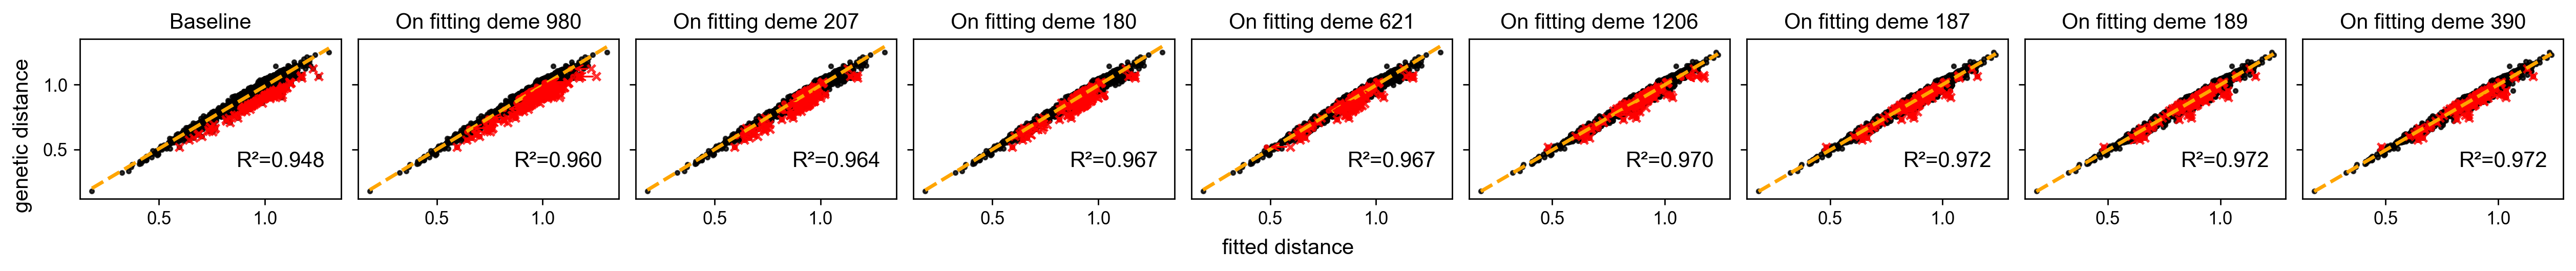

In [236]:
# import networkx as nx
# freqs = np.zeros_like(wolves_graph.frequencies)
# for i, node_id in enumerate(permuted_idx[:94]):
#     s = nx.get_node_attributes(wolves_graph, "sample_idx")[node_id]

#     # compute mean at each node
#     freqs[i,:] = np.mean(wolves_graph.genotypes[s,:], axis=0)/2
#     # freqs[i,:] = np.sum(sp_graph_jt.genotypes[s,:], axis=0)

# het = 2*freqs*(1-freqs)
# plt.plot(wolves_graph.s2[:94],het.mean(axis=1),'o',alpha=0.5)
# alls = np.zeros((sp_graph_jt.genotypes.shape[1],2))
# plot_results(ind_results, dpi=250, figsize=(20,2))

In [396]:
# med_spacemix = [0.01937429,0.01587325,0.006617999,0.004845347,0.006708163,0.00401827,0.0122487,0.00482947,0.002456252,0.002708504,0.1000575,0.1273344,0.004317822,0.003019414,0.002672921,0.09961773,0.003418695,0.003509599,0.004024112,0.004007152,0.002642361,0.002530899,0.002384085,0.004048692,0.002563896,0.002027101,0.003977936,0.003677587,0.002896895,0.0024975,0.003149439,0.004312738,0.00227444,0.002233898,0.00183585,0.003061934,0.003979968,0.002955401,0.003338955,0.003397887,0.003521155,0.004141994,0.002927201,0.003589331,0.002817105,0.002839483,0.003985941,0.002373238,0.004032835,0.004593606,0.003228359,0.003257948,0.002662256,0.003007602,0.005200164,0.004152379,0.003113858,0.002885949,0.00408016,0.003088208,0.004521971,0.008347207,0.003670392,0.1787385,0.0041278,0.01117924,0.004548573,0.003416117,0.005115239,0.001657582,0.003911237,0.003545994,0.00273064,0.002594609,0.002706837,0.003127315,0.003432761,0.004177043,0.0009712552,0.003704936,0.006351901,0.002827244,0.003718221,0.005222881,0.007940766,0.004053953,0.003225135,0.001104474,0.002350154,0.07508196,0.004172863,0.002832125,0.001829685,0.1905081]
# low_spacemix = [0.000897215,0.000883515,0.0003152308,0.0001783414,0.0001263806,0.0002117441,0.0005691187,0.0001017287,0.0001441438,0.0001115783,0.01455387,0.009495504,0.0001391555,0.0002546154,0.0001033251,0.01418984,0.00009573956,0.0001252788,0.0001894526,0.0001786773,0.00002211429,0.000128457,0.0003422592,0.00008624158,0.0002547229,0.00004294275,0.0002931522,0.0000114855,0.0001440366,0.0001177462,0.00003943307,0.00004251546,0.0001998847,0.0001160401,0.00008392832,0.0001051864,0.0001626113,0.00009667649,0.0001383472,0.0001124294,0.0001933383,0.0001970422,0.00007637774,0.0001894598,0.0001693688,0.0001144978,0.000143404,0.0001543102,0.0002778853,0.00009854014,0.0001856883,0.0001230146,0.00003003104,0.0002553205,0.0004264873,0.0001960061,0.00001612395,0.00002108883,0.0003152421,0.000115327,0.0001492339,0.0001476192,0.0002845236,0.1262221,0.00003898708,0.0005145195,0.0002264754,0.00002980656,0.0002916458,0.0001520485,0.00003570642,0.0002020343,0.0001778328,0.0002384659,0.0001526563,0.00000255398,0.00004213508,0.00006416699,0.00004324126,0.00001642329,0.0003001758,0.000053435,0.00006740519,0.0002366941,0.0003375228,0.00002340561,0.0001733865,0.00004652174,0.00007655947,0.01808362,0.0002585558,0.00003214257,0.0001024796,0.1322754]
# upp_spacemix = [0.06045592,0.05188655,0.02948005,0.01913859,0.02871016,0.01999014,0.04940507,0.0208047,0.0221807,0.0168951,0.1478331,0.2002445,0.03671032,0.01448133,0.01237573,0.1607841,0.01388515,0.02734635,0.02258282,0.01891659,0.01537074,0.01564139,0.009627474,0.01826564,0.01896702,0.01236076,0.01249714,0.02085416,0.01279819,0.01738598,0.02163806,0.0291359,0.009757326,0.01491553,0.01398314,0.01479675,0.01537421,0.01336835,0.01662656,0.02430628,0.02067816,0.021131,0.009807138,0.01912948,0.01652029,0.01698084,0.01606524,0.01587904,0.01332922,0.02609124,0.02049717,0.01600329,0.0153979,0.01870126,0.03292576,0.02144142,0.01532726,0.01603268,0.01431206,0.01558017,0.01982415,0.04019233,0.02308869,0.2217451,0.02262178,0.04293267,0.01811621,0.02045679,0.0264703,0.01258225,0.02452506,0.02202632,0.02442458,0.01137278,0.01640466,0.01783253,0.01470676,0.01861735,0.00508181,0.02384039,0.04139652,0.01457178,0.02139582,0.02858446,0.04494716,0.02277083,0.01732321,0.008245681,0.01162835,0.1250916,0.01875431,0.01677644,0.01087549,0.2379548]

In [780]:
# contour_dict = {} 180, 207, 1206, 980, 621
# for deme in [980, 207, 621, 180, 402, 189, 585, 187, 390, 747, 815, 1206]:
#     contour_dict[deme] = wolves_graph.calc_contour(destid=deme, search_area='all', exclude_boundary=False)
# joint_contour_dict = {}
# for deme in [980, 207, 621, 180, 402, 189, 585, 187, 390, 747, 815, 1206]:
#     joint_contour_dict[deme] = wolves_graph.calc_joint_contour(2., 1., contour_df=contour_dict[deme], top=30)

	Jointly optimizing likelihood over 2/30 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:467: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


	Jointly optimizing likelihood over 14/30 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 652, increase atol or factr slightly)
	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!
	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!
	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!
	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!
	Jointly optimizing likelihood over 5/30 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 275, increase atol or factr slightly)
	Jointly optimizing likelihood over 16/30 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 274, increase atol or factr slightly)
	Jointly optimizing likelihood over 18/30 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 146, increase atol or factr slightly)
	Jointly optimizing likelihoo

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:467: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!
	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!
	Jointly optimizing likelihood over 3/30 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:467: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


	Jointly optimizing likelihood over 21/30 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 662, increase atol or factr slightly)
	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!
	Jointly optimizing likelihood over 11/30 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:467: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!
	Jointly optimizing likelihood over 20/30 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:467: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


	Jointly optimizing likelihood over 29/30 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 920, increase atol or factr slightly)
	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!
	Jointly optimizing likelihood over 10/30 most likely demes in the graph

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:467: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


	Jointly optimizing likelihood over 25/30 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 1137, increase atol or factr slightly)
	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!
	Jointly optimizing likelihood over 10/30 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 1075, increase atol or factr slightly)
	Jointly optimizing likelihood over 13/30 most likely demes in the graph(Warning: admix. prop. optimization failed for deme 956, increase atol or factr slightly)
	Jointly optimizing likelihood over 30/30 most likely demes in the graph...done!


In [415]:
admix_df = pd.DataFrame(columns=['med_spacemix','low_spacemix','upp_spacemix','FEEMS_mle','dest.','type'],index=range(94))
spacemix_demes = [35, 42, 129,  180,  185,  207,  621,  632,  980, 1206]
# contour_df1206['admix. prop.'].iloc[contour_df1206['scaled log-lik'].argmax()]
# np.unique(outliers_df['dest.'])
for i in range(wolves_graph.n_observed_nodes):
    admix_df['dest.'].iloc[i] = poporder['id'].iloc[i]
    admix_df['med_spacemix'].iloc[i] = med_spacemix[i]
    admix_df['low_spacemix'].iloc[i] = low_spacemix[i]
    admix_df['upp_spacemix'].iloc[i] = upp_spacemix[i]

    if admix_df['dest.'].iloc[i] in contour_dict.keys():
        admix_df['FEEMS_mle'].iloc[i] = contour_dict[admix_df['dest.'].iloc[i]]['admix. prop.'].iloc[contour_dict[admix_df['dest.'].iloc[i]]['scaled log-lik'].argmax()]
        if admix_df['dest.'].iloc[i] in spacemix_demes:
            admix_df['type'].iloc[i] = 'FEEMS & SpaceMix'
        else:
            admix_df['type'].iloc[i] = 'FEEMS not SpaceMix'
    else:
        if admix_df['dest.'].iloc[i] in spacemix_demes:
            admix_df['type'].iloc[i] = 'SpaceMix not FEEMS'
        else:
            admix_df['type'].iloc[i] = 'Neither'
        admix_df['FEEMS_mle'].iloc[i] = np.nan

plt.figure(dpi=120)
plt.plot(admix_df['FEEMS_mle'].loc[admix_df['type']=='FEEMS not SpaceMix'],admix_df['med_spacemix'].loc[admix_df['type']=='FEEMS not SpaceMix'],'o',color='#fc8d62',alpha=0.8,label='FEEMS not SpaceMix'); plt.errorbar(admix_df['FEEMS_mle'].loc[admix_df['type']=='FEEMS not SpaceMix'],admix_df['med_spacemix'].loc[admix_df['type']=='FEEMS not SpaceMix'],yerr=np.array((admix_df['low_spacemix'].loc[admix_df['type']=='FEEMS not SpaceMix'].values,admix_df['upp_spacemix'].loc[admix_df['type']=='FEEMS not SpaceMix'].values)),fmt='none',color='#fc8d62',alpha=0.8)
plt.plot(admix_df['FEEMS_mle'].loc[admix_df['type']=='FEEMS & SpaceMix'],admix_df['med_spacemix'].loc[admix_df['type']=='FEEMS & SpaceMix'],'o',color='#8da0cb',alpha=0.8,label='FEEMS & SpaceMix'); plt.errorbar(admix_df['FEEMS_mle'].loc[admix_df['type']=='FEEMS & SpaceMix'],admix_df['med_spacemix'].loc[admix_df['type']=='FEEMS & SpaceMix'],yerr=np.array((admix_df['low_spacemix'].loc[admix_df['type']=='FEEMS & SpaceMix'].values,admix_df['upp_spacemix'].loc[admix_df['type']=='FEEMS & SpaceMix'].values)),fmt='none',color='#8da0cb',alpha=0.8); plt.legend(); plt.grid(); plt.box(False); plt.axline((0,0),slope=1,color='grey')
plt.xlabel('FEEMS MLE estimate'); plt.ylabel('SpaceMix posterior distribution'); 

In [328]:
# admix_df.loc[admix_df['type']=='SpaceMix not FEEMS']
# import pickle
## with open('/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/wolves/joint_contour_dict_ndim.pkl', 'wb') as fp:
##     pickle.dump(joint_contour_dict, fp)
##     print('dictionary saved successfully to file')
# with open('/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/wolves/joint_contour_dict_ndim.pkl', 'rb') as fp:
#     joint_contour_dict = pickle.load(fp)
# np.savetxt('wolvesadmix_nodepos.csv', np.vstack((wolves_graph.node_pos.T, [wolves_graph.nodes[n]['n_samples'] for n in range(len(wolves_graph.nodes))])).T, delimiter=',')
# np.savetxt('wolvesadmix_lambcv_edgew.csv', np.vstack((np.array(wolves_graph.edges).T, wolves_graph.w)).T, delimiter=',')

{'deme': 980,
 'contour_df':      (source, dest.)  admix. prop.       log-lik  scaled log-lik
 1           (4, 980)      0.307143 -34560.984184      -96.085278
 2           (6, 980)      0.307429 -34563.828298      -98.929392
 3           (7, 980)      0.294204 -34575.915185     -111.016279
 4           (8, 980)      0.306012 -34561.987734      -97.088828
 5          (10, 980)      0.310702 -34557.236028      -92.337122
 ...              ...           ...           ...             ...
 1041     (1190, 980)      0.176492 -34812.409991     -347.511085
 1042     (1191, 980)      0.163995 -34814.293711     -349.394805
 1043     (1192, 980)      0.157764 -34815.761592     -350.862687
 1044     (1197, 980)      0.175467 -34808.909528     -344.010622
 1045     (1198, 980)      0.180833 -34810.866141     -345.967235
 
 [1045 rows x 4 columns],
 'joint_contour_df':     (source, dest.)  admix. prop.       log-lik  scaled log-lik           pval
 561      (650, 980)      0.409797 -34464.127592    

In [759]:
def get_resmat(c, sp_graph, obj, lrn, mode):
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.broadcast_to(np.diag(obj.Linv),(o,o)).T + np.broadcast_to(np.diag(obj.Linv),(o,o)) #np.reshape(np.diag(obj.Linv[:o,:o]),(-1,1)) @ np.ones((1,sp_graph.n_observed_nodes)) + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = np.broadcast_to(sp_graph.q_inv_diag.diagonal(),(o,o)) #np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag     

    if mode=='sampled':
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
    else:
        neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
            # finds the neighboring deme that has samples
        neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

        R1d = -2*obj.Lpinv[lrn[0][0],lrn[0][1]] + obj.Lpinv[lrn[0][0],lrn[0][0]] + obj.Lpinv[lrn[0][1],lrn[0][1]]
        R1 = np.array(-2*obj.Lpinv[:sp_graph.n_observed_nodes,lrn[0][0]].T + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]])

        # apply this formula only to neighboring sampled demes
        for n in neighs:
            # convert back to appropriate indexing excluding the unsampled demes
            s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==n][0]
            # (1+c)q_s gives an overestimate of the c value (slide 61) ->  keeping it at 1-c
            resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
            resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

        proxs = np.argmin([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set([k for k, v in nx.get_node_attributes(sp_graph,'n_samples').items() if v>0])-set([lrn[0][0]])])
        # qprox = np.dot(1/self.sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
        qprox = np.dot(1/sp_graph.q[proxs], (R1[0,proxs]*np.exp(-2*R1[0,proxs]))/np.sum(R1[0,proxs]*np.exp(-2*R1[0,proxs])))
        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
            Ri1 = -2*obj.Lpinv[i,lrn[0][0]] + obj.Lpinv[i,i] + obj.Lpinv[lrn[0][0],lrn[0][0]]
            # resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/self.sp_graph.q[i] + (1-c)/self.sp_graph.q[opts  ['lre'][0][1]] + c/self.sp_graph.q[proxs]
            # should there be a (1+c)q_d here?
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c*qprox
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
  
    return resmat
# import networkx as nx

In [408]:
# df = obj.calc_contour(destid=980, search_area='all', delta=opts['delta'])
# obj = FEEMSmix_Objective(wolves_graph); obj.inv(); obj.Lpinv = np.linalg.pinv(obj.sp_graph.L.todense()); obj.grad(reg=False)

# opts['edge'] = [df['(source, dest.)'].iloc[df['log-lik'].argmax()]]; opts['mode'] = 'update'
# print(obj.eems_neg_log_lik(c=df['admix. prop.'].iloc[np.argmax(df['log-lik'])], opts=opts))

# plt.imshow(opts['delta']-obj.compute_delta_matrix(0.5,{'lre':[(1,93)],'source':'sampled','delta':opts['delta']})); plt.colorbar()
# res_dist = np.array(cov_to_dist(-0.5*opts['delta'])[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)])
# outliers_df = obj.extract_outliers(fdr=0.25, res_dist=res_dist, verbose=False)
# projection = ccrs.AzimuthalEquidistant(central_longitude=-108.842926, central_latitude=66.037547)   
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=4, cbar_font_size=10, cbar_ticklabelsize=8)
# v.draw_map(latlong=[[50,60],[-140,-100,-60]]); ax.set_extent([-155, -65, 37, 80]); v.draw_obs_nodes(use_ids=True)
# v.draw_admixture_arrows(seq_results)
# for i in range(1,len(results)):
#     v.draw_ll_contour(results[i]['contour_df'], levels=[-10,0])
#     v.draw_arrow([results[i]['contour_df']['(source, dest.)'].iloc[np.argmax(results[i]['contour_df']['log-lik'])]], 
#                  results[i]['contour_df']['admix. prop.'].iloc[np.argmax(results[i]['contour_df']['log-lik'])])
# contour_df980 = wolves_graph.calc_contour(destid=980)
# wolves_graph.edge = []
# get_outlier_idx(seq_results[0]['emp_dist'], seq_results[3]['fit_dist'])
# seq_results[6]['pval']

In [438]:
# from feems.utils import benjamini_hochberg, get_outlier_idx
# np.sum(benjamini_hochberg(emp_dist, res_dist, 0.25))
# outliers_df = obj.extract_outliers()
# idx = get_outlier_idx(emp_dist, res_dist, 0.25)
# vals, cnts = np.unique(np.array(idx)[:,0], return_counts=True)
# np.unique(np.array(idx)[:,0], return_counts=True)
# obj.perm_idx[vals[np.argsort(cnts)[-1]]]
# pd.concat([outliers_df['source'], outliers_df['dest.']]).value_counts().iloc[:5]
# obj.sequential_fit(fdr=0.001, stop=10)
# obj.calc_contour(destid=np.int32(980),search_area='radius',opts=3) 
%time seq_results = wolves_graph.sequential_fit(outliers_df,fdr=0.05,stop=3,top=5,lamb=2.,lamb_q=1.,optimize_q='n-dim')
# ind_results = wolves_graph.independent_fit(outliers_df,stop=2,top=5,lamb=2.,lamb_q=1.)
# df = wolves_graph.calc_contour(destid=980)

Log-likelihood of initial fit: -34831.0

Deme ID and # of times it was implicated as an outlier:
980     78
207     24
180     19
621     14
1206    10
Name: dest., dtype: int64

Fitting admixture edge to deme 980:
  Optimizing likelihood over 1045 demes in the graph...25%...50%...75%...done!
[]
	Optimizing joint likelihood over 5/5 most likely demes in the graph...done!

  Log-likelihood after fitting deme 980: -34463.8
Previous edge to deme 980 significantly increased the log-likelihood.

Using a FDR of 0.05: 76 outlier deme pairs found
Putative destination demes: [ 207  180  621 1206  187  815  980  189  350  390  402  585  747]
Deme ID and # of times it was implicated as an outlier:
207     22
180     17
621     14
1206     8
187      5
Name: dest., dtype: int64

Fitting admixture edge to deme 207:
  Optimizing likelihood over 1040 demes in the graph...25%...50%...75%...done!
[(651, 980)]
	Optimizing joint likelihood over 5/5 most likely demes in the graph...done!

  Log-likelihood

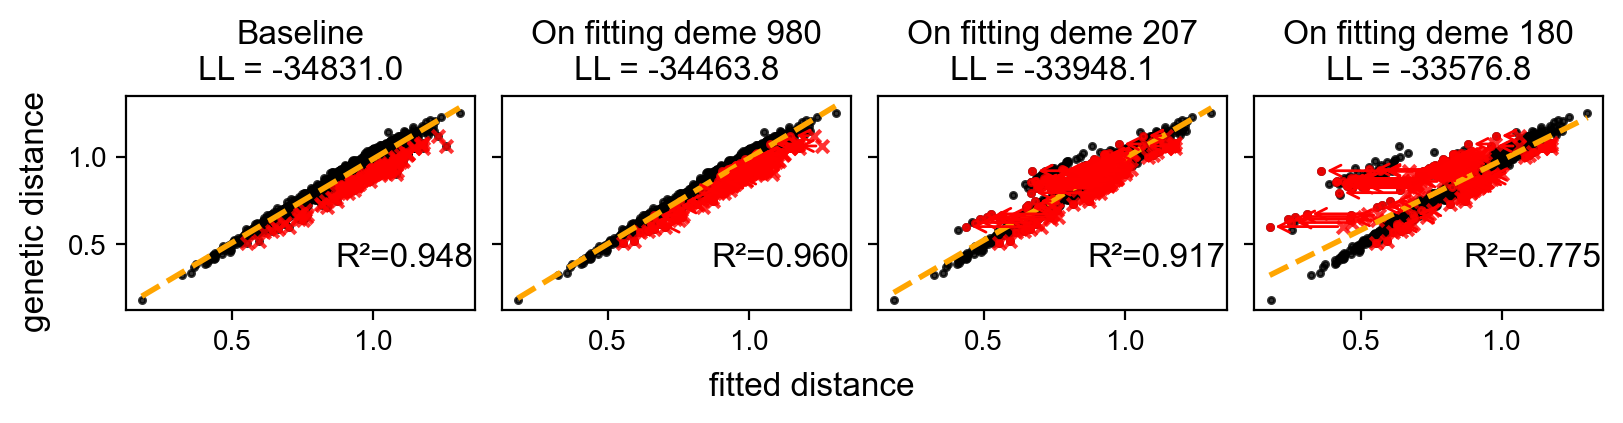

In [439]:
# from feems.viz import plot_FEEMSmix_result
plot_FEEMSmix_result(seq_results, figsize=(8,2))
# pointll = wolves_graph.calc_contour(destid=980,search_area='radius',opts=3,sourceid=contour_dict[980]['(source, dest.)'].iloc[contour_dict[980]['scaled log-lik'].argmax()][0])['log-lik'].to_list()
# jointll = wolves_graph.calc_joint_contour(destid=980,lamb=2.,lamb_q=1.,search_area='radius',opts=3,sourceid=contour_dict[980]['(source, dest.)'].iloc[contour_dict[980]['scaled log-lik'].argmax()][0])['log-lik'].to_list()
# for deme in [180,207,621,1206,250]:
#     jointll.append(wolves_graph.calc_joint_contour(destid=deme,lamb=2.,lamb_q=1.,search_area='range',opts=[[-130,-160],[60,80]])['log-lik'])
#     pointll.append(wolves_graph.calc_contour(destid=deme,search_area='range',opts=[[-130,-160],[60,80]])['log-lik'].to_list())
# [x if i<119 else y for y in x for i, x in enumerate(pointll)]
# newpointll = []; newjointll = []
# for i, x in enumerate(jointll):
#     if i<119:
#         newjointll.append(x)
#     else:
#         for y in x:
#            newjointll.append(y)
# plt.plot(newjointll[:118],newpointll[:118],'o',label='980',alpha=0.7); plt.grid(); #plt.axline((-34400,-34400),slope=1,color='red'); 
# plt.plot(newjointll[118:2*118],newpointll[118:2*118],'o',label='180',alpha=0.7)
# for rep, deme in enumerate([207,621,1206,250]):
#     plt.plot(newjointll[(rep+2)*118:(rep+3)*118],newpointll[(rep+2)*118:(rep+3)*118],'o',label=str(deme),alpha=0.7)
# plt.ylabel('log-likelihood from point fit'); plt.xlabel('log-likelihood from joint fit'); plt.axline((-35000,-35000),slope=1,color='red'); plt.legend(title='deme ID')
# sp.stats.pearsonr(newjointll,newpointll,nan_policy='omit')
# sm.qqplot((np.log(emp_dist)-np.log(res_dist)-np.mean(np.log(emp_dist)-np.log(res_dist)))/np.std(np.log(emp_dist)-np.log(res_dist),ddof=1),line='45')

Text(0.5, 1.0, 'fitting line through quartiles')

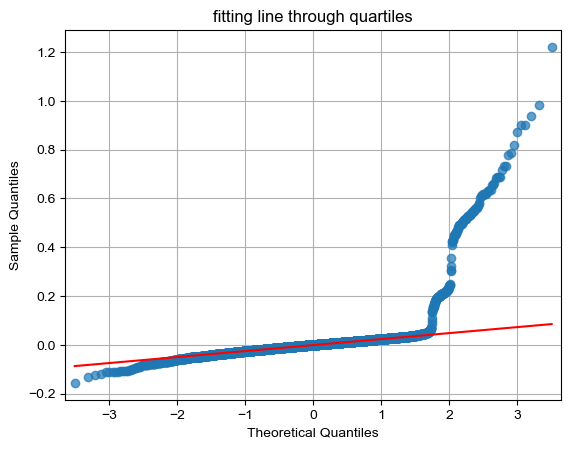

In [440]:
# lamb_grid = np.geomspace(2e-3,2e3,10,endpoint=True)[::-1]
# cvq_err = run_cv_joint(wolves_graph, lamb_grid=lamb_grid, lamb_q_grid=np.array([0.1, 1., 10.]))
# cv10_err = run_cv_joint(wolves_graph, lamb_grid=lamb_grid, lamb_q_grid=lamb_grid, n_folds=10)
# plt.plot(lamb_grid,mean_cv_err,'-ko',alpha=0.9); plt.xlabel(r'$\lambda$'); plt.ylabel('LOO-CV error'); plt.axvline(lamb_grid[np.argmin(mean_cv_err)],color='orange'); plt.semilogx()
# plt.plot(lamb_grid,np.mean(cvq_err[:,2,:],axis=0),'-o',color='grey',alpha=0.9,label='10'); plt.xlabel(r'$\lambda$'); plt.ylabel('LOO-CV error'); 
# plt.plot(lamb_grid,np.mean(cvq_err[:,1,:],axis=0),'-o',color='grey',alpha=0.6,label='1'); plt.plot(lamb_grid,np.mean(cvq_err[:,0,:],axis=0),'-o',color='grey',alpha=0.3,label='0.1'); plt.semilogx(); plt.legend(title=r'$\lambda_q$'); plt.grid()
# plt.plot(lamb_grid,mean_cv_err,'bo'); plt.semilogx(); plt.axvline(lamb_grid[np.argmin(mean_cv_err)], color='goldenrod'); plt.grid(); plt.ylabel('LOO-CV error'); plt.xlabel(r'$\lambda$')
# plt.savefig('/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/wolves/nonadmixed_LOOCV.png',dpi=150,bbox_inches='tight')
# plt.imshow(np.min(np.mean(cvq_err,axis=0))-np.mean(cvq_err,axis=0),cmap='Blues'); plt.colorbar(); plt.xlabel(r'$\lambda_q$'); plt.ylabel(r'$\lambda_w$'); 
# np.unravel_index(np.argmin(np.mean(cvq_err,axis=0)),(10,10))
logratio = np.log(seq_results[0]['emp_dist']/seq_results[3]['fit_dist'])
# mean_logratio = np.mean(logratio)
# var_logratio = np.var(logratio,ddof=1)
# logratio_norm = (logratio-mean_logratio)/np.sqrt(var_logratio)
# from feems.utils import get_robust_normal_pvals_lower
# plt.hist(get_robust_normal_pvals_lower(logratio, 0.25)[0],20); plt.title('on fitting 3 edges')
sm.qqplot(logratio,alpha=0.7,line='q'); plt.grid(); plt.title('fitting line through quartiles')
# sm.qqplot(logratio_norm,alpha=0.7,line='s'); plt.grid(); plt.title('fitting line through standardized normal')
# [seq_results[i]['contour_df']['admix. prop.'].loc[np.nanargmax(seq_results[i]['contour_df']['log-lik'])]  for i in range(1,len(seq_results))]

### Using $\texttt{FEEMSmix}$ as a spatial assignment prediction tool (comparing to Karl's workflow)

(array([2.000e+00, 1.000e+00, 1.000e+01, 2.000e+01, 3.400e+01, 1.030e+02,
        3.930e+02, 2.366e+03, 2.760e+02, 1.110e+02, 5.800e+01, 2.800e+01,
        1.200e+01, 1.400e+01, 9.000e+00, 1.100e+01, 6.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00]),
 array([-0.03032843, -0.0261772 , -0.02202598, -0.01787476, -0.01372353,
        -0.00957231, -0.00542109, -0.00126986,  0.00288136,  0.00703259,
         0.01118381,  0.01533503,  0.01948626,  0.02363748,  0.02778871,
         0.03193993,  0.03609115,  0.04024238,  0.0443936 ,  0.04854482,
         0.05269605]),
 <BarContainer object of 20 artists>)

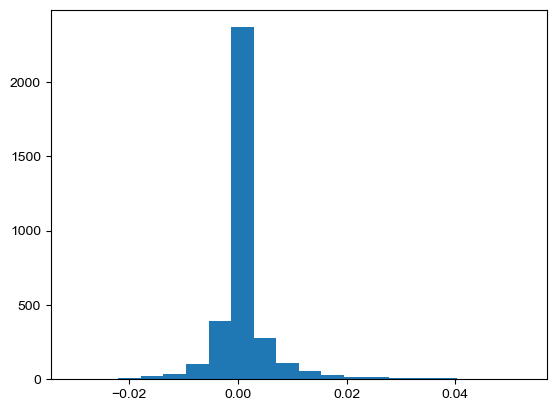

In [442]:
## assinging individuals to a random location on the grid and predicting its true location as a source
# choose deme 834 with sample id 41 
# coordwo834 = deepcopy(coord)
# coordwo834[85,] = np.array([-70, 55])
# wolves_graph.calc_contour(destid=980, sourceid=207, search_area='radius', opts=3)
# wolves_graph_wo834 = FEEMSmix_SpatialGraph(genotypes, coordwo834, grid, edges)
# wolves_graph_wo834.fit(lamb=2., optimize_q='n-dim', lamb_q=2.)
# obj_wo834 = FEEMSmix_Objective(wolves_graph_wo834); obj_wo834.Lpinv = np.linalg.pinv(wolves_graph_wo834.L.todense()); obj_wo834.inv(); obj_wo834.grad(reg=False)
# outliers_df = obj_wo834.extract_outliers(0.1) # 973 or 687
# contour_calc687 = obj_wo834.calc_contour(destid=973, search_area='all')
# np.sum(wolves_graph.n_samples_per_obs_node_permuted==1)
plt.hist(seq_results[3]['mle_w'] - seq_results[2]['mle_w'], bins=20)

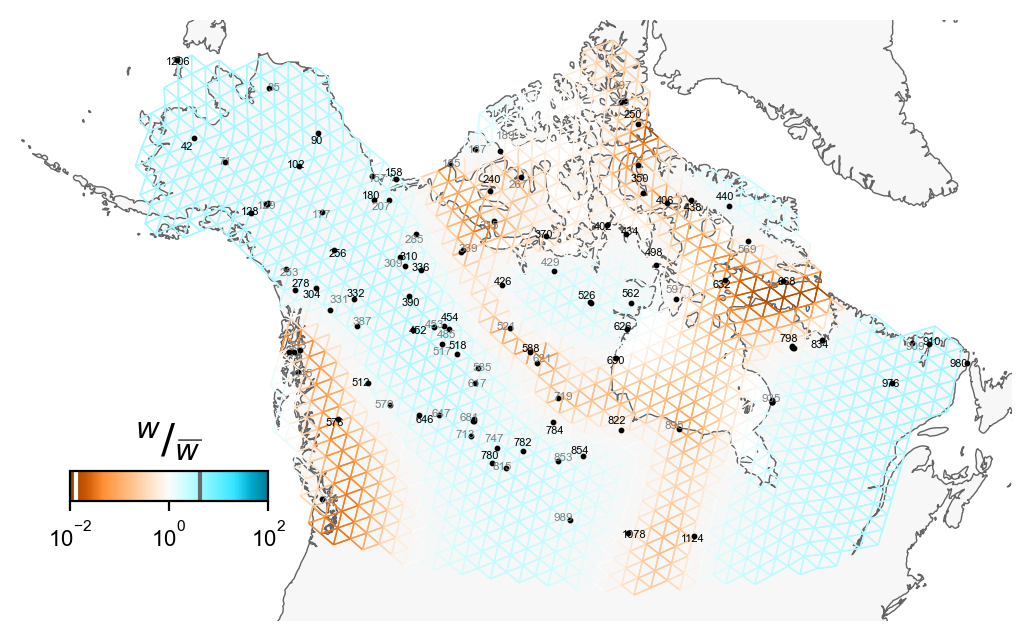

In [443]:
# projection = ccrs.AzimuthalEquidistant(central_longitude=-108.842926, central_latitude=66.037547)   
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=4, cbar_font_size=10, cbar_ticklabelsize=8)
v.draw_samples(); v.draw_map(latlong=False); ax.set_extent([-145, -65, 37, 80]); 
v.draw_obs_nodes(use_ids=True)
v.draw_edges(use_weights=True); v.draw_edge_colorbar()
# v.draw_loglik_contour(joint_contour_dict[1206])
# v.ax.plot(v.grid[719,0], v.grid[719,1], 'rx', markersize=4)
# v.ax.plot(v.grid[687,0], v.grid[687,1], 'bo', markersize=4)
# for i in range(outliers_df.shape[0]):
#     v.ax.plot([v.grid[outliers_df['source'].iloc[i],0],v.grid[outliers_df['dest.'].iloc[i],0]],[v.grid[outliers_df['source'].iloc[i],1],v.grid[outliers_df['dest.'].iloc[i],1]],linewidth=0.4,color='grey')
# for dest in np.unique(outliers_df['dest.']):
#     v.ax.plot(v.grid[dest, 0], v.grid[dest, 1], 'o', color='dodgerblue', markersize=10*np.log10(np.sum(outliers_df['dest.']==dest)+1), alpha=0.5)      
# plt.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/wolves_none_resid.pdf')
# v.draw_ll_contour(contour_calc687, levels=[-20,0])
# v.draw_arrow([(contour_calc687['(source, dest.)'].iloc[np.argmax(contour_calc687['scaled log-lik'])][0],687)],0.85)

In [680]:
## creating a sample dictionary mapping sample ids to observed demes
## (below is the predicted deme positions using the FEEMSmix pipeline)
resdemes = [929,940,832,903,647,452,517,646,487,708,366,369,366,557,489,590,253,452,518,444,583,394,682,517,646,713,713,832,832,910,833,937,834,833,149,113,95,51,904,1192,1003,909,867,1119,782,853,815,452,713,914,747,913,842,1051,617,576,508,445,444,433,217,435,537,197,223,224,440,187,266,409,569,440,266,408,189,213,188,530,590,463,464,498,366,493,466,457,491,374,128,177,309,384,128,256,456,387,304,253,253,331,356,304,278,579,177,90,102,35,128,71,385]
locator = pd.read_csv('/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/wolves/locator_predlocs.csv',header=None)
sample_dict = {}
for i in range(94):
    if len(wolves_graph.nodes[wolves_graph.perm_idx[i]]['sample_idx'])==1:
        sample_dict[i] = wolves_graph.nodes[wolves_graph.perm_idx[i]]['sample_idx']
    else:
        sample_dict[i] = wolves_graph.nodes[wolves_graph.perm_idx[i]]['sample_idx']
ind_dict = {}
for i in range(111):
    for s in range(94):
        if i in sample_dict[s]:
            ind_dict[i] = s
# ind_dict[12]
# true_coord = np.array([v.grid[obj.perm_idx[ind_dict[i]],:].tolist() for i in range(111)])
# pred_coord = np.array([v.grid[resdemes[i],:].tolist() for i in range(111)])
latlong_true = coord#np.array([wolves_graph.nodes[obj.perm_idx[ind_dict[i]]]['pos'].tolist() for i in range(111)])
latlong_pred = np.array([wolves_graph.nodes[resdemes[i]]['pos'].tolist() for i in range(111)])
latlong_loc_true = np.array(locator.iloc[:,:2]); latlong_loc_pred = np.array(locator.iloc[:,2:])

In [855]:
from matplotlib import collections  as mc
from feems.viz import project_coords
def draw_prediction(self, true_coord, pred_coord, ec='red'):
    # draw line segments
    lines = [(true_coord[i], pred_coord[i]) for i in range(pred_coord.shape[0])]
    lc = mc.LineCollection(lines, colors=ec, linewidths=1.5)
    self.ax.add_collection(lc)

    # draw true coordinates
    self.ax.scatter(
        true_coord[:, 0],
        true_coord[:, 1],
        edgecolors="black",
        s=2,
        alpha=self.obs_node_alpha,
        color=self.obs_node_color,
        zorder=self.obs_node_zorder,
    )
    
    # draw predicted coordinates
    self.ax.scatter(
        pred_coord[:, 0],
        pred_coord[:, 1],
        edgecolors=ec,
        color=ec,
        s=2,
        alpha=self.obs_node_alpha,
        zorder=self.obs_node_zorder,
    )

def plot_predictions(true_coord, pred_coord, projection, sp_graph, option='FEEMSmix'):
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=projection)  
    v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
            edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
            obs_node_size=7.5, sample_pt_color="black", 
            cbar_font_size=10)
    v.draw_map(latlong=False)
    
    # projected_true_coord = project_coords(true_coord, v.proj)
    # projected_pred_coord = project_coords(pred_coord, v.proj)
    if option=='FEEMSmix':
        draw_prediction(v, true_coord, pred_coord)
    else:
        projected_true_coord = project_coords(true_coord, v.proj)
        projected_pred_coord = project_coords(pred_coord, v.proj)
        draw_prediction(v, projected_true_coord, projected_pred_coord)
    return v

def plot_two_predictions(true_coord, pred_coord, true_coord1, pred_coord1, project, sp_graph):
    ## the first set of coords should always be FEEMSmix
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=project)  
    v = Viz(ax, sp_graph, projection=project, edge_width=.5, 
            edge_alpha=1, edge_zorder=100, sample_pt_size=40, 
            obs_node_size=7.5, sample_pt_color="black", 
            cbar_font_size=10)
    v.draw_map(latlong=False); v.draw_edges(use_weights=True)
    
    draw_prediction(v, project_coords(true_coord, v.proj), project_coords(pred_coord, v.proj), ec='#FF5733')
    
    projected_true_coord = project_coords(true_coord1, v.proj)
    projected_pred_coord = project_coords(pred_coord1, v.proj)
    draw_prediction(v, projected_true_coord, projected_pred_coord, ec='#6DAA6C') #ff7f0e
    return v

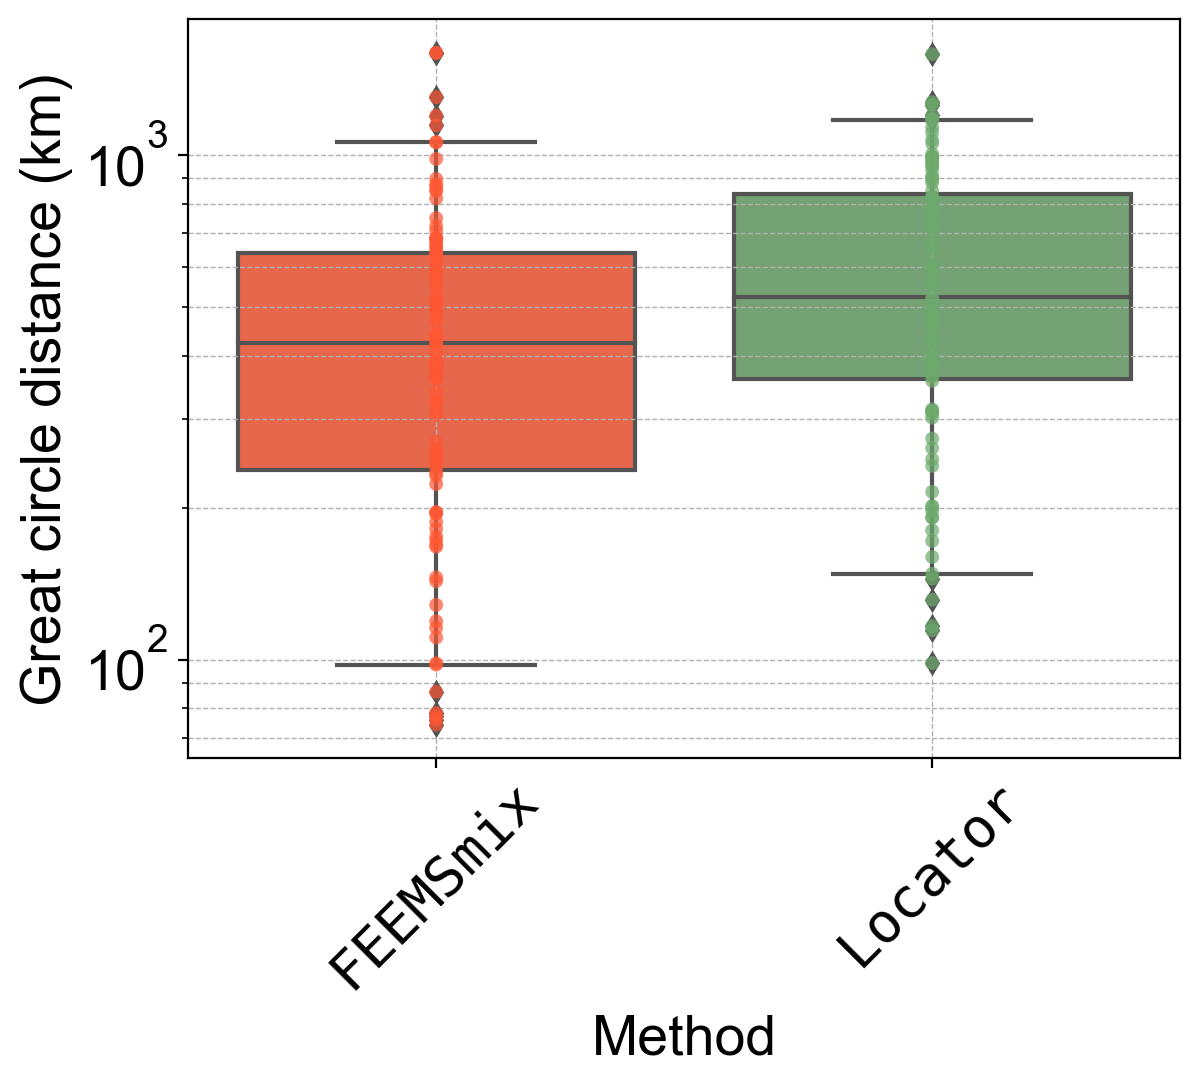

In [863]:
# data = {'Method': ['FEEMSmix'] * len(haversine_distance(latlong_true, latlong_pred)) + ['Locator'] * len(comp_dist(latlong_loc_true, latlong_loc_pred)),
#         'Distance': list(haversine_distance(latlong_true, latlong_pred)) + list(haversine_distance(latlong_loc_true, latlong_loc_pred))}
# plt.rcParams.update({'font.size': 22})
# custom_colors = ["#FF5733", "#6DAA6C"]
plt.figure(dpi=200)
sns.stripplot(x='Method', y='Distance', data=data, jitter=False, alpha=0.7, hue='Method',legend=False, palette=custom_colors)
sns.boxplot(x='Method', y='Distance', data=data, whis=[5, 95], palette=custom_colors)
plt.xticks(ticks=[0, 1], rotation=45, labels=[r'$\tt{FEEMSmix}$', r'$\tt{Locator}$']); plt.semilogy()
plt.ylabel('Great circle distance (km)'); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.rcParams.update({'font.size': 20})
# for i in range(len(distances)):
#     plt.plot([0, 1], [data['Distance'][i],data['Distance'][i+len(distances)]], color='gray', linestyle='-', linewidth=1, alpha=0.8)

In [862]:
sp.stats.ttest_ind(haversine_distance(latlong_true, latlong_pred), haversine_distance(latlong_loc_true, latlong_loc_pred), equal_var=False)

Ttest_indResult(statistic=-2.5943239741368367, pvalue=0.010194320653536235)

In [837]:
# def comp_dist(a, b):
#     return np.sqrt(((a - b)**2).sum(1))
# def haversine_distance(coord_set1, coord_set2):
#     """
#     Calculate the great circle distance between two sets of points
#     on the earth (specified in decimal degrees)
#     """
#     # Convert decimal degrees to radians
#     lon1, lat1, lon2, lat2 = map(np.radians, [coord_set1[:,0], coord_set1[:,1],
#                                               coord_set2[:,0], coord_set2[:,1]])

#     # Haversine formula
#     dlon = lon2 - lon1
#     dlat = lat2 - lat1
#     a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
#     c = 2 * np.arcsin(np.sqrt(a))
#     r = 6371 # Radius of earth in kilometers
#     return c * r
    
# distances = comp_dist(np.abs(latlong_true), np.abs(latlong_pred))
# sns.boxplot(data=[distances,comp_dist(np.array(feems_true), np.array(feems_pred)),comp_dist(latlong_loc_true, latlong_loc_pred)]); plt.xticks(ticks=[0,1,2],rotation=45,labels=['FEEMSmix','Spatial Prediction','Locator']); 
# sns.boxplot(data=[distances,comp_dist(latlong_loc_true, latlong_loc_pred)]); plt.xticks(ticks=[0,1],rotation=45,labels=[r'$\tt{FEEMSmix}$',r'$\tt{Locator}$']); 
# plt.ylabel('Euclidean distance'); plt.grid()
# np.median(haversine_distance(latlong_true, latlong_pred)), np.median(haversine_distance(latlong_loc_true, latlong_loc_pred))
# joint_contour
# plt.hist(np.log10(distances), alpha=0.8, label='FEEMSmix', bins=12); 
# plt.hist(np.log10(comp_dist(np.array(feems_true), np.array(feems_pred))), label='Spatial Prediction', alpha=0.6); 
# plt.hist(np.log10(comp_dist(latlong_loc_true, latlong_loc_pred)), label='Locator', alpha=0.4, bins=12)
# plt.grid(); plt.legend(); plt.xlabel(r'$\log_{10}(\mathrm{Euclidean\  distance})$'); plt.yticks(ticks=[0,5,10,15,20])
# plt.plot(latlong_true[:,0],latlong_true[:,1],'ko'); 
# plt.plot(latlong_pred[:,0],latlong_pred[:,1],'o',label='FEEMSmix'); plt.plot(np.array(feems_pred)[:,0],np.array(feems_pred)[:,1],'o',label='Spatial Prediction'); plt.legend(); plt.grid(); plt.ylabel('Latitude'); plt.xlabel('Longitude'); 

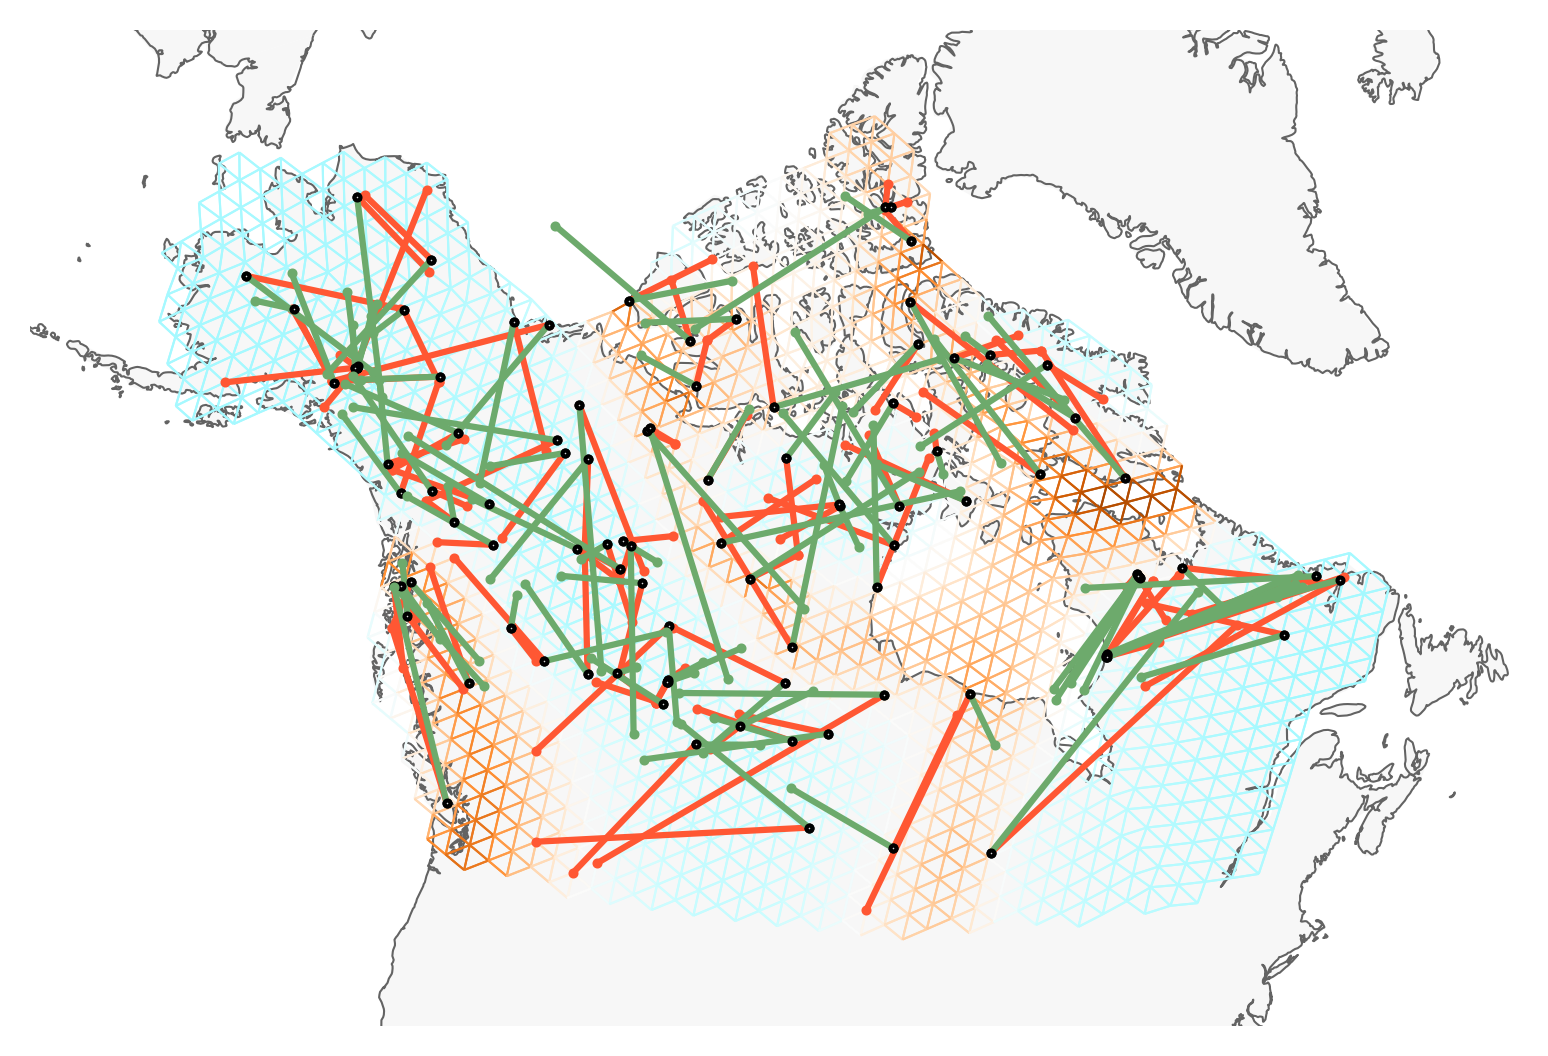

In [856]:
# wolves_graph.fit(lamb=2.,long_range_edges=[(250,402)],option='onlyc'); print(wolves_graph.c)
# obj.eems_neg_log_lik(wolves_graph.c,{'edge':obj.sp_graph.edge,'mode':'compute'}), contour_df980.iloc[20:30]

# joint_df980 = pd.read_csv("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/wolves/joint_df980.csv", index_col=0,
#                          dtype={'(source, dest.)': 'string'})
# joint_df980['(source, dest.)'] = joint_df980['(source, dest.)'].apply(eval)
# joint_df980['scaled log-lik'] = joint_df980['log-lik']-np.nanmax(joint_df980['log-lik'])

# projection = ccrs.AzimuthalEquidistant(central_longitude=-100, central_latitude=60)   
# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, abs_max=2,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=4)
# v.draw_samples(); v.draw_map(latlong=False); v.draw_edges(use_weights=True); v.draw_edge_colorbar(); v.draw_obs_nodes()
# v.draw_ll_contour(joint_df980, levels=[-10])

# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)
# v = Viz(ax, wolves_graph, projection=projection, edge_width=1, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_samples(); v.draw_map(latlong=False);
# v.draw_arrow(wolves_graph.edge, wolves_graph.c) 
v.ax.plot()
v.draw_edges(use_weights=True); #v.draw_obs_nodes()
# plt.show(plot_predictions(latlong_true, latlong_pred, projection, wolves_graph))
# plt.show(plot_predictions(latlong_true, latlong_pred, projection, wolves_graph, 'not FEEMS'))
# plt.show(plot_predictions(latlong_true, latlong_pred, projection, wolves_graph, 'not FEEMS'))
plt.show(plot_two_predictions(latlong_true, latlong_pred, latlong_loc_true, latlong_loc_pred, projection, wolves_graph))
# feems_true = []; feems_pred = []
# for r in res:
#     feems_true.append(res[r]['true_coord'].tolist()[0])
#     feems_pred.append(res[r]['map_coord'].tolist()[0])

In [233]:
# def split_df(ids):
#     joint_df = pd.DataFrame(columns=['(source, dest.)', 'admix. prop.', 'log-lik'])
#     for d in ids:
#         sd = (d, 980)
#         try:
#             wolves_graph.fit(lamb=5.,optimize_q='n-dim',lamb_q=1.,option='default',verbose=False)
#             obj = FEEMSmix_Objective(wolves_graph); obj.inv(); obj.grad(reg=False)
#             try:
#                 wolves_graph.fit(lamb=5.,long_range_edges=[sd],optimize_q='n-dim',lamb_q=1.,option='onlyc',verbose=False)
#                 obj = FEEMSmix_Objective(wolves_graph); obj.inv(); obj.grad(reg=False)
#             except:
#                 try:
#                     wolves_graph.fit(lamb=50.,long_range_edges=[sd],optimize_q='n-dim',lamb_q=10.,option='onlyc')
#                     obj = FEEMSmix_Objective(wolves_graph); obj.inv(); obj.grad(reg=False)
#                 except:
#                     joint_df.loc[len(joint_df)] = [sd, np.nan, np.nan]
#                     continue
#         except:
#             joint_df.loc[len(joint_df)] = [sd, np.nan, np.nan]
#             continue
            
#         joint_df.loc[len(joint_df)] = [sd, wolves_graph.c[0], -obj.eems_neg_log_lik(wolves_graph.c, {'edge':wolves_graph.edge,'mode':'compute'})]

#     return joint_df

# split_ids = np.array_split(list(np.arange(980)) + list(np.arange(981,1201)),16)
# pdlist = Parallel(n_jobs=-1,backend='threading')(delayed(split_df)(split_ids[i][-3:]) for i in range(16))

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 array([68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
 array([84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])]

In [396]:
def regularize_frequencies(self, alpha):
    """
    update attributes frequencies and S in self
    compute weighted average of global freuqencies
    and and observed node frequencies
    """
    self.factor = None
    sp_graph = deepcopy(self)

    n = self.n_samples_per_obs_node_permuted
    mu = self.mu
    scale = np.sqrt(mu * (1-mu))

    f = self.frequencies * scale
    f_reg = (1 - alpha / n)[:, None] * f + (alpha / n)[:, None] * mu * 2
    
    sp_graph.frequencies = f_reg / scale
    sp_graph.S = sp_graph.frequencies @ sp_graph.frequencies.T / sp_graph.n_snps

    return sp_graph

In [309]:
# n = wolves_graph.sample_pos.shape[0]
# split = np.array([False]*91 + [True] + [False]*19)
# from feems.cross_validation import train_test_split
# wolves_graph.factor = None
# sp_graph_train, sp_graph_test = train_test_split(wolves_graph, split)
# sp_graph_train = regularize_frequencies(sp_graph_train, -0.5)
# test_sample_idx = query_node_attributes(sp_graph_test, 'sample_idx')
# test_node2sample = {i: test_sample_idx[i]
#     for i in range(len(test_sample_idx))
#     if len(test_sample_idx[i]) > 0}
# test_nodes = list(test_node2sample.keys())
# sp_graph_train.fit(lamb=20., verbose=True)
# g = deepcopy(wolves_graph.genotypes)
# g[~np.isclose(g, g.astype(int))] = np.nan
# from feems.spatial_prediction import predict_deme_point_mu
# z, post_mean = predict_deme_point_mu(g, sp_graph_train)
# np.unique(wolves_graph.node_pos[permuted_idx][z.argmax(1)])
from feems.spatial_prediction import leave_node_out_spatial_prediction
res = leave_node_out_spatial_prediction(wolves_graph, predict_type='point_mu', fit_feems=False, fit_kwargs={})

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:445: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


fit feems w/o observations @ node: 35
constant-w/variance fit, converged in 133 iterations, train_loss=197093.192
fit feems w/o observations @ node: 42
constant-w/variance fit, converged in 137 iterations, train_loss=196385.741
fit feems w/o observations @ node: 71
constant-w/variance fit, converged in 139 iterations, train_loss=196771.941
fit feems w/o observations @ node: 90
constant-w/variance fit, converged in 139 iterations, train_loss=198162.530
fit feems w/o observations @ node: 102
constant-w/variance fit, converged in 134 iterations, train_loss=196046.360
fit feems w/o observations @ node: 128
constant-w/variance fit, converged in 139 iterations, train_loss=197347.659
fit feems w/o observations @ node: 129
constant-w/variance fit, converged in 138 iterations, train_loss=219419.601
fit feems w/o observations @ node: 157
constant-w/variance fit, converged in 133 iterations, train_loss=197596.129
fit feems w/o observations @ node: 158
constant-w/variance fit, converged in 138 ite

In [451]:
# plt.scatter(qdf.iloc[94:,1],wolves_graph.q_prox,alpha=0.6); plt.grid()
# plt.get_cmap('Purples')(norm(0.3))

### Adding admixture edges to FEEMS plot with MLE $c$ values

In [12]:
# edges: 980, 207, 621, 180, 185, 189, 585, 187, 390, 747, 815, 1206
from matplotlib import cm, colormaps
projection = ccrs.AzimuthalEquidistant(central_longitude=-100, central_latitude=60)   
# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=4, cbar_font_size=10, cbar_ticklabelsize=10)
# v.draw_samples()
# v.draw_map(latlong=False); ax.set_extent([-145, -65, 37, 80]); v.draw_obs_nodes(); v.draw_edges(use_weights=True); v.draw_edge_colorbar()
# fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('Purples')), ax=v.ax, shrink=0.3, orientation='horizontal', values=np.linspace(np.min(qdf.iloc[:,1]),np.max(qdf.iloc[:,1])), location='top'); norm = plt.Normalize(np.min(qdf.iloc[:,1]),np.max(qdf.iloc[:,1]))
# for i in range(1207):
# # for i in range(94):
# #     # v.ax.plot(grid[np.where(permuted_idx==contour_df980['(source, dest.)'].iloc[i][0])[0][0],0],grid[np.where(permuted_idx==contour_df980['(source, dest.)'].iloc[i][0])[0][0],1],marker='$'+str(np.where(permuted_idx==contour_df980['(source, dest.)'].iloc[i][0])[0][0],)+'$',color='grey',alpha=0.8,markersize=4.5,transform=ccrs.EquidistantConic(central_longitude=grid[permuted_idx[i],0], central_latitude=grid[permuted_idx[i],1]),)
# #     # v.ax.plot(grid[permuted_idx[contour_df980['(source, dest.)'].iloc[i][0]],0],grid[permuted_idx[contour_df980['(source, dest.)'].iloc[i][0]],1],marker='$'+str(np.where(permuted_idx==contour_df980['(source, dest.)'].iloc[i][0])[0][0],)+'$',color='grey',alpha=0.8,markersize=4.5,transform=ccrs.EquidistantConic(central_longitude=grid[np.where(permuted_idx==contour_df980['(source, dest.)'].iloc[i][0])[0][0],0], central_latitude=grid[np.where(permuted_idx==contour_df980['(source, dest.)'].iloc[i][0])[0][0],1]),)
#     if i < wolves_graph.n_observed_nodes:
#         v.ax.scatter(grid[permuted_idx[i],0],grid[permuted_idx[i],1],marker='s',edgecolors='grey',color=colormaps.get_cmap('Purples')(norm(qdf.iat[i,1])),alpha=1,s=20,transform=ccrs.EquidistantConic(central_longitude=grid[permuted_idx[i],0], central_latitude=grid[permuted_idx[i],1]),)
#     else:
#        v.ax.plot(grid[permuted_idx[i],0],grid[permuted_idx[i],1],'o',color=colormaps.get_cmap('Purples')(norm(qdf.iat[i,1])),alpha=0.8,markersize=2.5,transform=ccrs.EquidistantConic(central_longitude=grid[permuted_idx[i],0], central_latitude=grid[permuted_idx[i],1]),)
    # v.ax.plot(grid[wolves_graph.perm_idx[i],0],grid[wolves_graph.perm_idx[i],1],'o',color='purple',alpha=0.5,markersize=6/wolves_graph.q[i],transform=ccrs.EquidistantConic(central_longitude=grid[wolves_graph.perm_idx[i],0], central_latitude=grid[wolves_graph.perm_idx[i],1]),)
# v.draw_obs_nodes(use_ids=False); #v.draw_edges(use_weights=True); v.draw_edge_colorbar(); 
# radius = 0.25; 
# v.draw_ll_contour(contour_dict[1206],levels=[-10,0]); 
# for i in obj.perm_idx[:94]:
#     # v.ax.plot(grid[permuted_idx[i],0],grid[permuted_idx[i],1],color=cols[i],markersize=3)
#     if i==1206:
#         #     draw_admix_pie(Q_k7[wolves_graph.nodes[i]['sample_idx'][0], :], v.grid[i, 0], v.grid[i, 1], colors_k7, radius=radius, ax=ax)
#         draw_admix_pie(np.mean(Q_k7[wolves_graph.nodes[i]['sample_idx'], :],axis=0).tolist(), v.grid[i, 0], v.grid[i, 1], colors_k7, radius=radius, ax=ax)
#     else:
#         #     draw_admix_pie(Q_k7[wolves_graph.nodes[i]['sample_idx'][0], :], v.grid[i, 0], v.grid[i, 1], colors_k7, radius=radius, ax=ax)
#         draw_admix_pie(np.mean(Q_k7[wolves_graph.nodes[i]['sample_idx'], :],axis=0).tolist(), v.grid[i, 0], v.grid[i, 1], colors_k7, radius=radius, ax=ax)
# v.ax.plot(obs_grid[permuted_idx[:94]==180,0], obs_grid[permuted_idx[:94]==180,1], 'o', color='#e9a3c9', alpha=0.8, markersize=10, label='winter (Nov-Apr)')
# v.ax.plot(obs_grid[permuted_idx[:94]==207,0], obs_grid[permuted_idx[:94]==207,1], 'o', color='#999999', alpha=0.8, markersize=10, label='unspecified (no month mentioned)')
# v.ax.plot(obs_grid[permuted_idx[:94]==935,0], obs_grid[permuted_idx[:94]==935,1], 'o', color='#a1d76a', alpha=0.8, markersize=10, label='summer (May-Oct)')
# for ip, p in enumerate(permuted_idx[:94]):
#         for i in wolves_graph.nodes[p]['sample_idx']:
#                 if str(wolvesdate['date'].iloc[i])!='nan':
#                         # v.ax.plot(obs_grid[ip, 0], obs_grid[ip, 1], 'o', color=colormaps.get_cmap('cool').resampled(2006-1991+1)(int(float(wolvesdate['date'].iloc[i].split('-')[1])-1993)), alpha=0.8, markersize=9)
#                         if wolvesdate['date'].iloc[i].split('-')[0] != '00':
#                                 v.ax.plot(obs_grid[ip, 0], obs_grid[ip, 1], 'o', color=colormaps.get_cmap('summer').resampled(12)(int(wolvesdate['date'].iloc[i].split('-')[0])), alpha=0.8, markersize=9)
                        # if wolvesdate['date'].iloc[i].split('-')[0] in winter:
                        #         v.ax.plot(obs_grid[ip, 0], obs_grid[ip, 1], 'o', color='#e9a3c9', alpha=0.8, markersize=10)
                        # elif wolvesdate['date'].iloc[i].split('-')[0]=='00':
                        #         # v.ax.plot(obs_grid[ip, 0], obs_grid[ip, 1], 'o', color='#999999', alpha=0.8, markersize=10)
                        #         continue
                        # else:
                        #         v.ax.plot(obs_grid[ip, 0], obs_grid[ip, 1], 'o', color='#a1d76a', alpha=0.8, markersize=10)
# v.ax.legend(loc='upper left', fontsize=8) 
# fig.colorbar(cm.ScalarMappable(cmap=colormaps.get_cmap('cool').resampled(2006-1993+1)), ax=v.ax, shrink=0.4, values=range(1991,2007), label='year of sampling', location='top', orientation='horizontal') 
# cb = fig.colorbar(cm.ScalarMappable(cmap=colormaps.get_cmap('summer').resampled(12)), values=range(12), ax=v.ax, shrink=0.4,label='month of sampling', location='top', orientation='horizontal')
# cb.set_ticks(np.array([2,5,8,11],dtype='int'), labels=['Mar','Jun','Sep','Dec'])
# v.draw_c_colorbar()
v.draw_c_colorbar(c_cbar_loc='upper right')
for e in [980, 207, 621, 180, 402, 189, 585, 187, 390, 747, 815, 1206]:
# #         # v.ax.plot(obs_grid[np.where(permuted_idx == e)[0], 0], obs_grid[np.where(permuted_idx == e)[0], 1], 'ro', markersize=3, alpha=0.5,)# transform=ccrs.EquidistantConic(central_longitude=obs_grid[np.where(permuted_idx == e)[0], 0][0], central_latitude=obs_grid[np.where(permuted_idx == e)[0], 1][0]))
        pe = joint_contour_dict[e]['(source, dest.)'].iloc[np.argmax(joint_contour_dict[e]['scaled log-lik'])]
# #         # v.draw_arrow([(np.where(permuted_idx==pe[0])[0][0],pe[1])],1.,lw=1.66,hw=1e5,hl=1e5,mode='unsampled',fs=0)
# #         # v.draw_arrow([(np.where(permuted_idx==pe[0])[0][0],pe[1])],contour_dict[e]['admix. prop.'].iloc[np.argmax(contour_dict[e]['scaled log-lik'])],lw=.5,hw=1e5,hl=1e5,mode='unsampled',fs=0)
        v.draw_arrow([(pe[0],pe[1])],joint_contour_dict[e]['admix. prop.'].iloc[np.argmax(joint_contour_dict[e]['scaled log-lik'])],tw=3,hw=6,hl=8)
        # v.draw_ll_contour(contour_dict[e],levels=-10); 
# pe = contour_dict[1206]['(source, dest.)'].iloc[np.argmax(contour_dict[1206]['scaled log-lik'])]
# v.draw_ll_contour(contour_dict[1206],levels=-10); 
# v.draw_arrow([(pe[0],1206)],contour_dict[1206]['admix. prop.'].iloc[np.argmax(contour_dict[1206]['scaled log-lik'])],tw=3,hw=6,hl=8)
# v.draw_obs_nodes()
# for i in range(outliers_df.shape[0]):
#     v.ax.plot([v.grid[outliers_df['source'].iloc[i],0],v.grid[outliers_df['dest.'].iloc[i],0]],[v.grid[outliers_df['source'].iloc[i],1],v.grid[outliers_df['dest.'].iloc[i],1]],linewidth=0.4,color='grey')
# for dest in np.unique(outliers_df['dest.']):
#     v.ax.plot(v.grid[dest, 0], v.grid[dest, 1], 'o', color='dodgerblue', markersize=10*np.log10(np.sum(outliers_df['dest.']==dest)+1), alpha=0.5)        
#     v.ax.text(
#         np.mean([obs_grid[np.where(permuted_idx==outliers_df['source'].iloc[i])[0][0], 0],obs_grid[np.where(permuted_idx==outliers_df['dest.'].iloc[i])[0][0], 0]]),
#         np.mean([obs_grid[np.where(permuted_idx==outliers_df['source'].iloc[i])[0][0], 1],obs_grid[np.where(permuted_idx==outliers_df['dest.'].iloc[i])[0][0], 1]]),
#         # str("{:d}, ({:.1e})".format(idx+1,outliers_df['pval'].iloc[i])),
#         str("{:d}".format(idx+1)),
#         horizontalalignment="center",
#         verticalalignment="center",
#         size=6, color='dodgerblue'
#     )

NameError: name 'v' is not defined

In [442]:
# contour_dict[1206]['scaled log-lik'].iloc[np.argmax(contour_dict[1206]['scaled log-lik'])]
# pe = contour_dict[189]['(source, dest.)'].iloc[np.argmax(contour_dict[189]['scaled log-lik'])]
# Q_k7[wolves_graph.nodes[187]['sample_idx'][0], :]
# [(wolvesdate['iid'].iloc[i],float(wolvesdate['date'].iloc[i].split('-')[1])) for i in np.where(~pd.isna(wolvesdate['date']))[0]]
# wolves_graph.nodes[585]
# np.argsort(outliers_df['pval'])
# colormaps.get_cmap('cool').resampled(2006-1993+1)

# zsc = sp.stats.zscore(emp_dist-fit_dist)#(emp_dist-fit_dist - np.nanmean(emp_dist-fit_dist))/np.nanstd(emp_dist-fit_dist)
# np.sum(np.isnan(zsc))
# plt.hist(zsc)
# zscmat = np.zeros((wolves_graph.n_observed_nodes,wolves_graph.n_observed_nodes))
# for i in range(len(np.tril_indices(wolves_graph.n_observed_nodes, k=-1)[0])):
#     zscmat[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)[0][i],np.tril_indices(wolves_graph.n_observed_nodes, k=-1)[1][i]] = zsc[i]
#     zscmat[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)[1][i],np.tril_indices(wolves_graph.n_observed_nodes, k=-1)[0][i]] = zsc[i]
# np.mean(Q_k7[wolves_graph.nodes[i]['sample_idx'], :],axis=0)
# plt.imshow(zscmat, vmin=-2, vmax=2); plt.colorbar()
# 1/wolves_graph.q

### Coloring each edge by a different label based on their mode of dispersal

In [130]:
xgfs_normal6 = ['#ebac23','#b80058','#bdbdbd','#008cf9']
style = "Simple, tail_width={}, head_width={}, head_length={}".format(4, 8, 12)
kw = dict(arrowstyle=style, 
          edgecolor='white', 
          facecolor='k', 
          zorder=5, 
          linewidth=0.1*3)

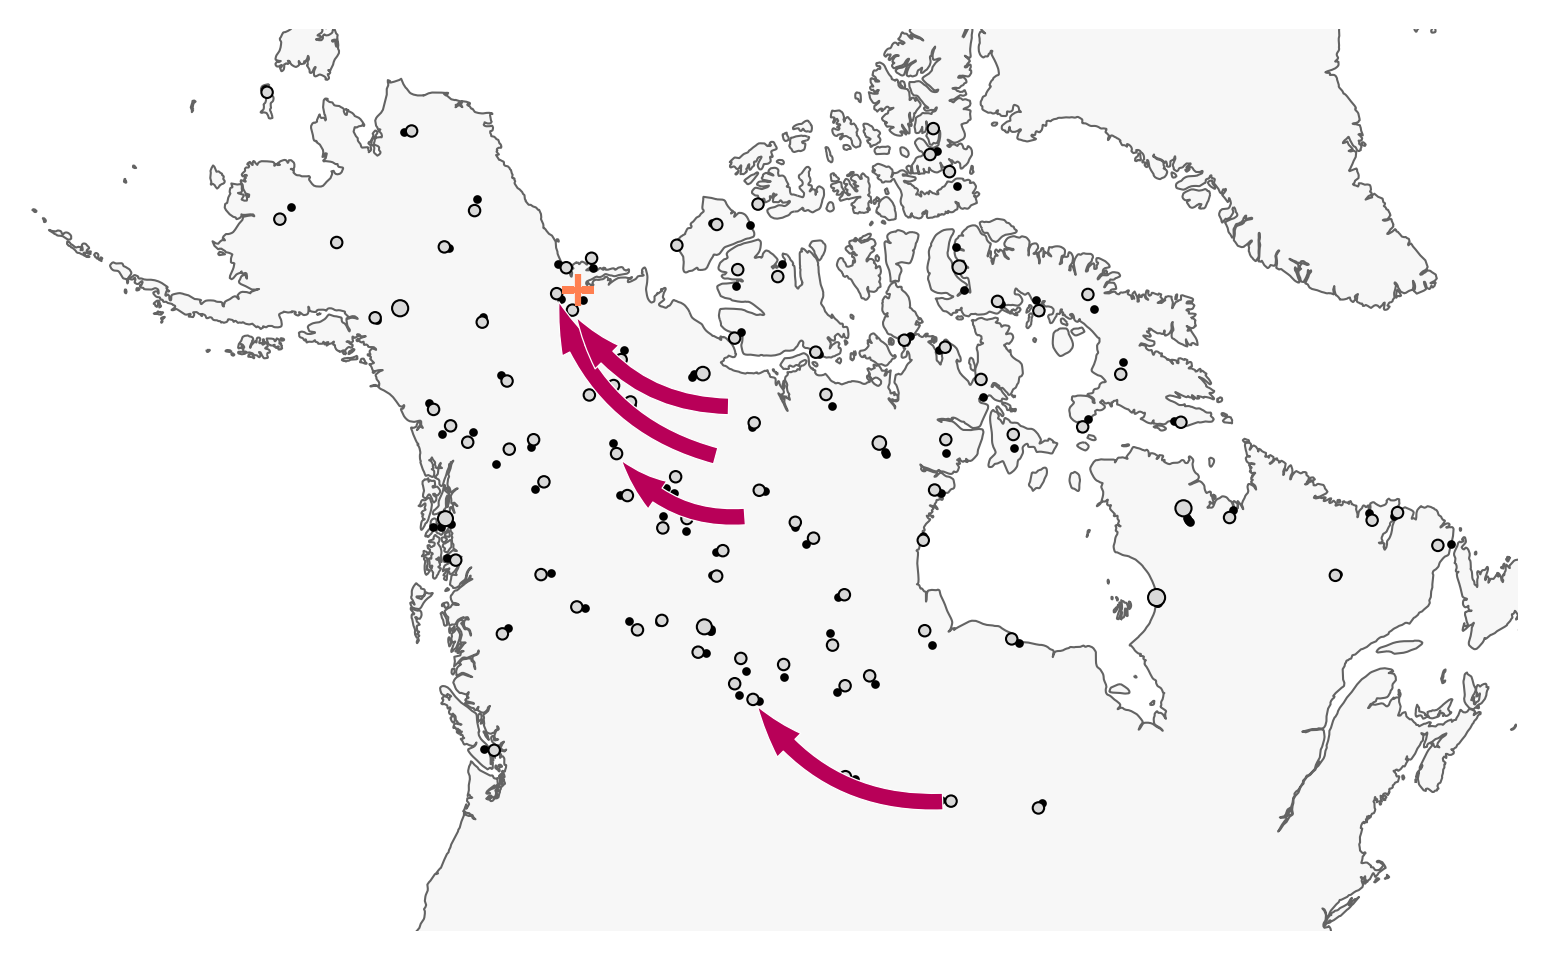

In [141]:
import matplotlib.patches as patches
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=4, cbar_font_size=10, cbar_ticklabelsize=10)
v.draw_samples()
v.draw_map(latlong=False); ax.set_extent([-145, -65, 37, 80]); v.draw_obs_nodes(); #v.draw_edges(use_weights=True); v.draw_edge_colorbar()
# for e in [180, 207]:
#     kw['facecolor'] = xgfs_normal6[1]
#     src = joint_contour_dict[e]['(source, dest.)'].iloc[np.argmax(joint_contour_dict[e]['scaled log-lik'])][0]
#     v.ax.add_patch(patches.FancyArrowPatch((v.grid[src,0],v.grid[src,1]), (v.grid[e,0],v.grid[e,1]), connectionstyle="arc3,rad=-.3", **kw))
v.ax.scatter(projection.transform_point(-133.723022,68.360741,ccrs.EquidistantConic(-133.723022,68.360741))[0], projection.transform_point(-133.723022,68.360741,ccrs.EquidistantConic(-133.723022,68.360741))[1], s=60, marker='+', zorder=2, facecolors='coral')
for e in [180, 207, 390, 815]:
    kw['facecolor'] = xgfs_normal6[1]
    src = joint_contour_dict[e]['(source, dest.)'].iloc[np.argmax(joint_contour_dict[e]['scaled log-lik'])][0]
    v.ax.add_patch(patches.FancyArrowPatch((v.grid[src,0],v.grid[src,1]), (v.grid[e,0],v.grid[e,1]), connectionstyle="arc3,rad=-.3", **kw))
# for e in [189, 621, 585]:
#     kw['facecolor'] = xgfs_normal6[0]
#     src = joint_contour_dict[e]['(source, dest.)'].iloc[np.argmax(joint_contour_dict[e]['scaled log-lik'])][0]
#     v.ax.add_patch(patches.FancyArrowPatch((v.grid[src,0],v.grid[src,1]), (v.grid[e,0],v.grid[e,1]), connectionstyle="arc3,rad=-.3", **kw))
# v.ax.scatter(projection.transform_point(-127,67,ccrs.EquidistantConic(-127,67))[0], projection.transform_point(-127,67,ccrs.EquidistantConic(-127,67))[1], s=50, marker='x', zorder=2, facecolors='coral')
# v.ax.plot([projection.transform_point(-127,67,ccrs.EquidistantConic(-127,67))[0],v.grid[621][0]],[projection.transform_point(-127,67,ccrs.EquidistantConic(-127,67))[1],v.grid[621][1]],color='coral')
# v.ax.scatter(projection.transform_point(-123,65,ccrs.EquidistantConic(-123,65))[0], projection.transform_point(-123,65,ccrs.EquidistantConic(-123,65))[1], s=50, marker='x', zorder=2, facecolors='coral')
# v.ax.plot([projection.transform_point(-123,65,ccrs.EquidistantConic(-123,65))[0],v.grid[585][0]],[projection.transform_point(-123,65,ccrs.EquidistantConic(-123,65))[1],v.grid[585][1]],color='coral')
# v.ax.scatter(projection.transform_point(-123,65,ccrs.EquidistantConic(-119.5,73.3))[0], projection.transform_point(-119.5,73.3,ccrs.EquidistantConic(-119.5,73.3))[1], s=50, marker='x', zorder=2, facecolors='coral')
# v.ax.plot([projection.transform_point(-123,65,ccrs.EquidistantConic(-119.5,73.3))[0],v.grid[189][0]],[projection.transform_point(-119.5,73.3,ccrs.EquidistantConic(-119.5,73.3))[1],v.grid[189][1]],color='coral')
# for e in [980, 1206, 402, 187, 747]:
#     kw['facecolor'] = xgfs_normal6[2]
#     src = joint_contour_dict[e]['(source, dest.)'].iloc[np.argmax(joint_contour_dict[e]['scaled log-lik'])][0]
#     v.ax.add_patch(patches.FancyArrowPatch((v.grid[src,0],v.grid[src,1]), (v.grid[e,0],v.grid[e,1]), connectionstyle="arc3,rad=-.3", **kw))
# patches = [patches.Patch(color=color, label=label) for color, label in zip(xgfs_normal6, ['known recording error','putative proxy location','remainder'])]
# plt.legend(handles=patches, loc='lower left', fontsize=10)

## Running a PCA on the demes from FEEMS

In [915]:
# [str(poporder.loc[w==poporder['id']]['id'].values[0]) for w in wolves_graph.assned_node_idx].index('1206')
# permuted_idx[:94], wolves_graph.genotypes[sample_idx[129], :].shape
projection.transform_point(-127,67,ccrs.EquidistantConic(-127,67))

(-1145691.3260828767, 1024193.15412564)

In [931]:
# import allel
# import matplotlib.patches as mpatches
# poporder = pd.read_csv('/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/wolves/poporder.txt',sep=' ',header=None,names=['id','col'])

# import networkx as nx
# permuted_idx = obj.perm_idx
# sample_idx = nx.get_node_attributes(wolves_graph, "sample_idx")
# gn = np.zeros((wolves_graph.n_snps,wolves_graph.n_observed_nodes))
# for i, node_id in enumerate(permuted_idx[:wolves_graph.n_observed_nodes]):
#     allele_counts = np.sum(wolves_graph.genotypes[sample_idx[node_id], :], axis=0)
#     gn[:,i] = allele_counts

# pcacoord, mod = allel.pca(wolves_graph.genotypes.T, n_components=1000, scaler='patterson')
# pcacoord, mod = allel.pca(gn, n_components=1000, scaler=None)
# WF = mpatches.Patch(color='#E6AB02', label='WestForest')
# BF = mpatches.Patch(color='#7570B3', label='BorealForest')
# Arc = mpatches.Patch(color='#1B9E77', label='Arctic')
# HA = mpatches.Patch(color='#66A61E', label='HighArctic')
# BC = mpatches.Patch(color='#E7298A', label='BritishColumbia')
# Oth = mpatches.Patch(color='#666666', label='Other')
# AF = mpatches.Patch(color='#D95F02', label='AtlanticForest')
# cols = [str(poporder.loc[w==poporder['id']]['col'].values[0]) for w in wolves_graph.assned_node_idx]
# fig = plt.figure(dpi=200)
# for i in range(wolves_graph.genotypes.shape[0]):
#     plt.scatter(pcacoord[i,0],pcacoord[i,1],s=250,marker='$'+str(poporder.loc[wolves_graph.assned_node_idx[i]==poporder['id']]['id'].values[0])+'$',c=cols[i],alpha=0.6)
#    # plt.scatter(pcacoord[i,0],pcacoord[i,1],s=100,c=cols[i],alpha=0.6)
# plt.xlabel('PC1 (0.04%)'); plt.ylabel('PC2 (0.038%)'); 
# legend = plt.legend(handles=[WF,BF,Arc,HA,BC,Oth,AF])
# for text, color in zip(legend.get_texts(), poporder['col'].unique()):
#     text.set_color(color)
# plt.xlabel('PC1 (0.045%)'); plt.ylabel('PC2 (0.042%)'); 
# plt.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/wolves_pca.pdf')

# fig = plt.figure(dpi=200)
# for i in range(wolves_graph.n_observed_nodes):
#     plt.scatter(pcacoord[i,0],pcacoord[i,1],s=250,marker='$'+str(permuted_idx[i])+'$',c=cols[i],alpha=0.6)
#     # plt.scatter(pcacoord[i,0],pcacoord[i,1],s=100,c=cols[i],alpha=0.6)
# plt.xlabel('PC1 (67%)'); plt.ylabel('PC2 (0.03%)'); 

In [91]:
# plt.plot(range(1,112), mod.explained_variance_ratio_,'-ko'); plt.xlabel('# of PCs'); plt.ylabel('PVE'); plt.grid(); plt.box(False)
# poporder['col'].unique()

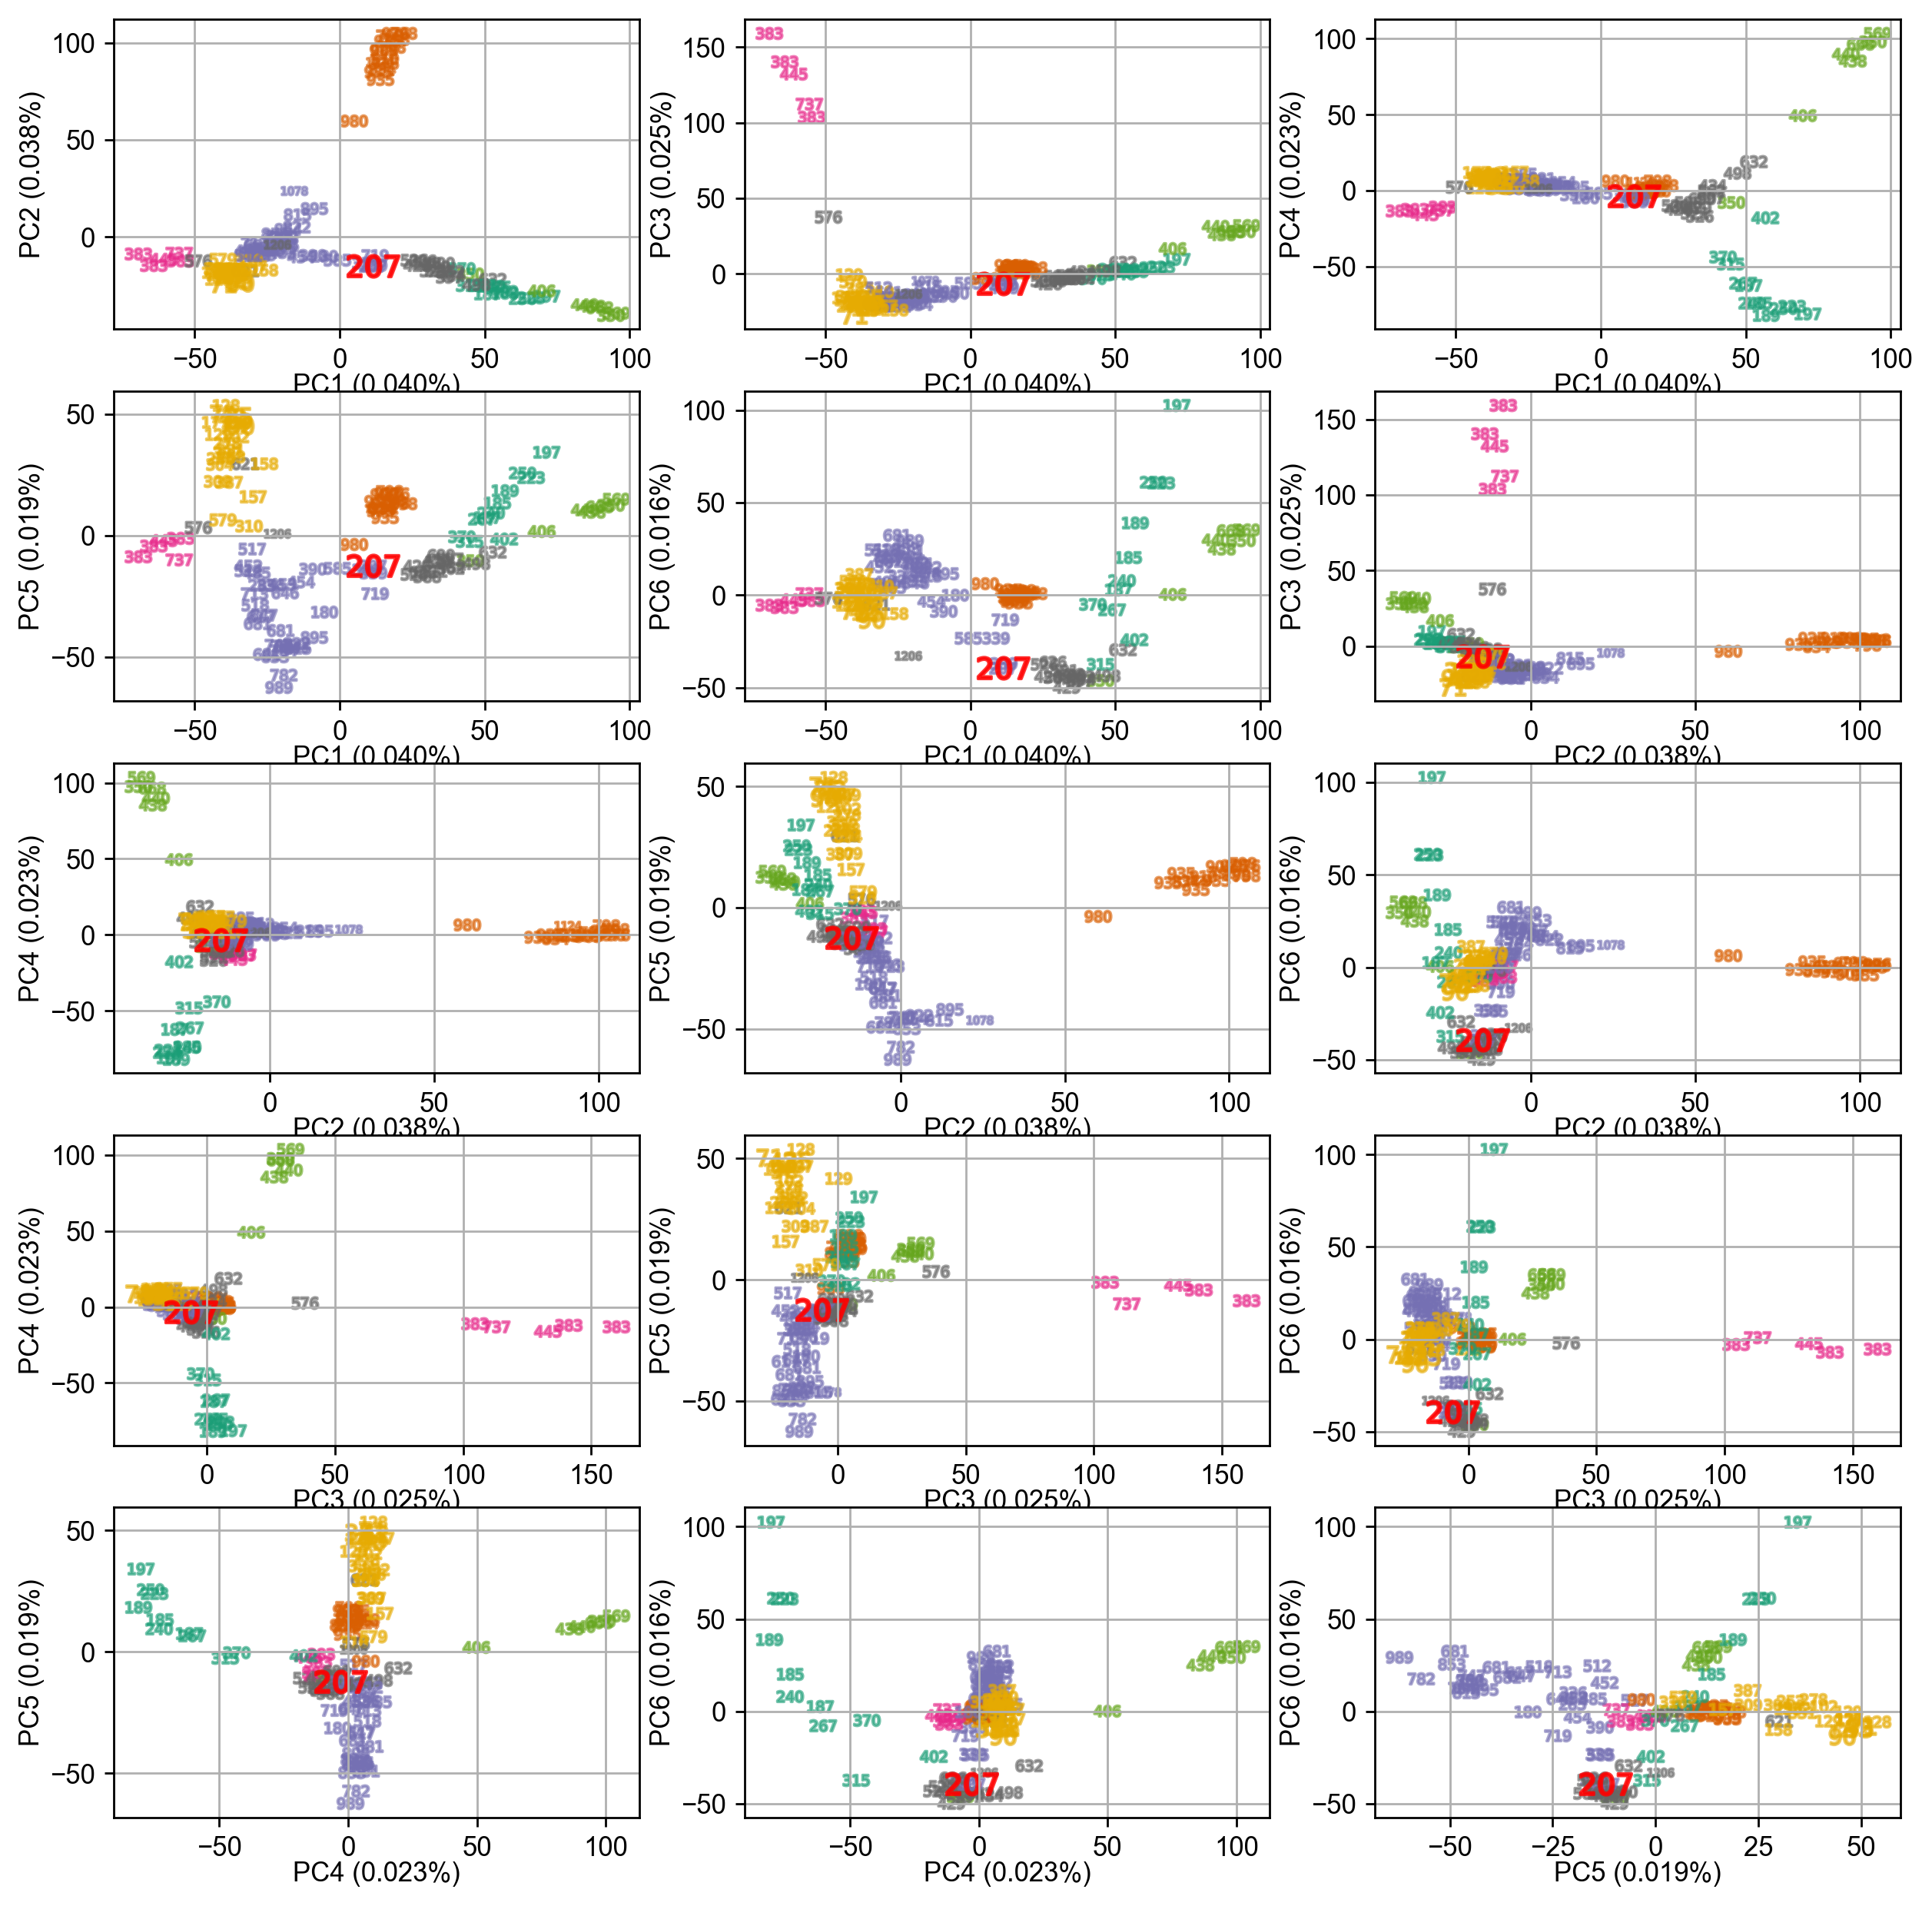

In [810]:
# from matplotlib import gridspec

deme = str(207)
idx = [str(poporder.loc[w==poporder['id']]['id'].values[0]) for w in wolves_graph.assned_node_idx].index(deme)

fig = plt.figure(dpi=250,figsize=(12,12))
plt.subplots_adjust(left=None, bottom=.1, right=None, top=None, wspace=None, hspace=.2)
for n, ticks in enumerate(list(it.combinations(range(6),2))):
    ax_00 = plt.subplot(5, 3, n + 1)
    ax_00.scatter(pcacoord[idx,ticks[0]],pcacoord[idx,ticks[1]],s=400,marker='$'+deme+'$',c='r',alpha=0.8); 
    for i in range(wolves_graph.genotypes.shape[0]):
        ax_00.scatter(pcacoord[i,ticks[0]],pcacoord[i,ticks[1]],s=100,marker='$'+str(poporder.loc[wolves_graph.assned_node_idx[i]==poporder['id']]['id'].values[0])+'$',c=cols[i],alpha=0.6)
    ax_00.set_xlabel('PC{:d} ({:.3f}%)'.format(ticks[0]+1,mod.explained_variance_ratio_[ticks[0]]),labelpad=0); ax_00.set_ylabel('PC{:d} ({:.3f}%)'.format(ticks[1]+1,mod.explained_variance_ratio_[ticks[1]]),labelpad=2); ax_00.grid()

### Code to compute the pairwise genetic distances as computed from PCA 

Text(0, 0.5, 'empirical distance')

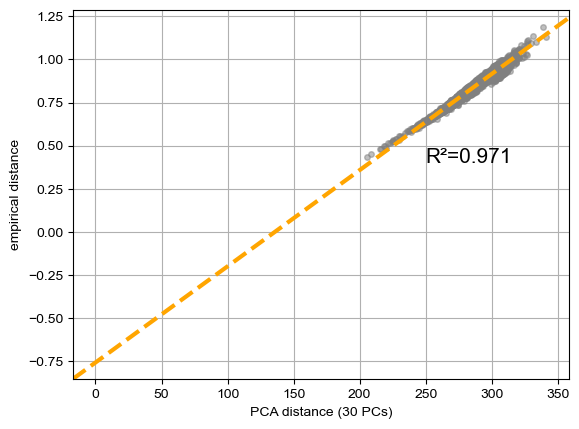

In [273]:
###### n, p = wolves_graph.genotypes.shape
# D_geno = squareform(pdist(genotypes, metric="sqeuclidean")) / p
# tril_idx = np.tril_indices(n, k=-1)
# y = D_geno[tril_idx]
pcdist = squareform(pdist(pcacoord[:,:111], metric='euclidean'))
x = pcdist[tril_idx]
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params

plt.plot(x, y, 'o', color='grey', alpha=0.5, markersize=4); plt.axline((0,muhat), slope=betahat, color='orange', ls='--', lw=3)
plt.text(250, 0.4, "R²={:.3f}".format(res.rsquared), fontsize=15); plt.grid(); #plt.ylim((0.25,1.25)); plt.xlim((200,350))
plt.xlabel('PCA distance (111 PCs)'); plt.ylabel('empirical distance')
# pcdist[np.tril_indices(wolves_graph.genotypes.shape[0],k=-1)]

### Using admixture $P$ and $Q$ matrices to compute genetic distance

In [75]:
# os.chdir('/Users/vivaswatshastry/src/feems/feems/data/wolves/')
# Q_k3 = np.loadtxt("wolvesadmix.7.Q")
# P_k3 = np.loadtxt("wolvesadmix.7.P")
# Q_k3 = np.loadtxt("tess3r.7.q")
# P_k3 = np.loadtxt("tess3r.7.p")
# G = Q_k3 @ P_k3.T
# admixdist = squareform(pdist(G, metric='euclidean'))
# x = admixdist[tril_idx]
# X = sm.add_constant(x)
# mod = sm.OLS(y, X)
# res = mod.fit()
# muhat, betahat = res.params

# plt.plot(x, y, 'o', color='grey', alpha=0.5, markersize=4); plt.axline((0,muhat), slope=betahat, color='orange', ls='--', lw=3)
# plt.text(15, 0.5, "R²={:.3f}".format(res.rsquared), fontsize=15); plt.grid(); #plt.ylim((0.25,1.25)); plt.xlim((200,350))
# plt.xlabel('tess3r distance (K = 7)'); plt.ylabel('empirical distance')
# plt.hist(np.sum(G, axis=0), bins=range(111,222,5), alpha=0.8, label=r'$2QP^\top$'); plt.xlabel('allele count')
# plt.hist(np.sum(wolves_graph.genotypes.T, axis=1), bins=range(111,222,5), alpha=0.5, label='Observed'); plt.legend(); plt.grid()

In [82]:
# plt.hist(res.resid,15); 
# max_res_node = []; pval = []
# for k in np.where(res.resid<sp.stats.norm.ppf(0.001,loc=0,scale=np.std(res.resid)))[0]:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
#     y = int(k - 0.5*x*(x-1))
#     max_res_node.append(sorted((x,y)))
#     pval.append(sp.stats.norm.cdf(res.resid[k],loc=0,scale=np.std(res.resid)))

# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_map(latlong=False); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# obs_grid = v.grid[query_node_attributes(wolves_graph, "permuted_idx")[:wolves_graph.n_observed_nodes],:]
# for ij, j in enumerate(np.unique(np.array(max_res_node)[:,1])):
#     for i in np.where(np.array(max_res_node)[:,1]==j)[0]:
#         v.ax.plot(
#             [obs_grid[max_res_node[i][0], 0],obs_grid[max_res_node[i][1],0]],
#             [obs_grid[max_res_node[i][0], 1],obs_grid[max_res_node[i][1],1]],
#             color = 'grey', linewidth = 0.2, alpha=0.95, ls='-.'
#         )
#         v.ax.text(
#             np.mean([obs_grid[max_res_node[i][0], 0],obs_grid[max_res_node[i][1], 0]]),
#             np.mean([obs_grid[max_res_node[i][0], 1],obs_grid[max_res_node[i][1], 1]]),
#             str("{:.1e}".format(pval[i])),
#             horizontalalignment="left",
#             verticalalignment="center",
#             size=v.obs_node_textsize*0.6
#         )
edges

array([[838, 839],
       [357, 386],
       [605, 637],
       ...,
       [834, 869],
       [  7,   8],
       [354, 381]])

In [131]:
os.chdir('/Users/vivaswatshastry/src/feems/feems/data/wolves/')
Q_k2 = np.loadtxt("wolvesadmix.2.Q")
Q_k3 = np.loadtxt("wolvesadmix.3.Q")
Q_k4 = np.loadtxt("wolvesadmix.4.Q")
Q_k5 = np.loadtxt("wolvesadmix.5.Q")
Q_k6 = np.loadtxt("wolvesadmix.6.Q")
Q_k7 = np.loadtxt("wolvesadmix.7.Q")
Q_k8 = np.loadtxt("wolvesadmix.8.Q")

#################### colors ####################
colors_k2 = ["#1b9e77", "#d95f02"] # x
colors_k3 = ["#1b9e77", "#d95f02", "#7570b3"] # x
colors_k4 = ["#7570b3", "#e7298a", "#d95f02", "#1b9e77"] # x
colors_k5 = ["#e7298a", "#66a61e", "#d95f02", "#1b9e77", "#7570b3"] # x 
colors_k6 = ["#1b9e77", "#e7298a", "#7570b3", "#e6ab02", "#d95f02", "#66a61e"] # x
colors_k7 = ["#e6ab02", "#a6761d", "#66a61e", "#7570b3", "#e7298a", "#1b9e77", "#d95f02"] # x 
colors_k8 = ["#1b9e77", "#e6ab02", "#d95f02", "#66a61e", "#666666", "#a6761d", "#7570b3", "#e7298a"] # x

In [129]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def draw_admix_pie(admix_fracs, 
                   x, y, 
                   colors,
                   radius=.18, 
                   inset_width=.5,
                   inset_height=.5,
                   loc=10,
                   linewidth=.2,
                   edgecolor="black",
                   ax=None):
    """Draws a single admixture pie on a axis
    """
    xy = (x, y)
    ax_i = inset_axes(ax, 
                      width=inset_width, 
                      height=inset_height, 
                      loc=loc, 
                      bbox_to_anchor=(x, y),
                      bbox_transform=ax.transData, 
                      borderpad=0)
    wedges, t = ax_i.pie(admix_fracs, 
                         colors=colors, 
                         center=xy, 
                         radius=radius, 
                         wedgeprops={"linewidth": linewidth, 
                                     "edgecolor": edgecolor})

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shap

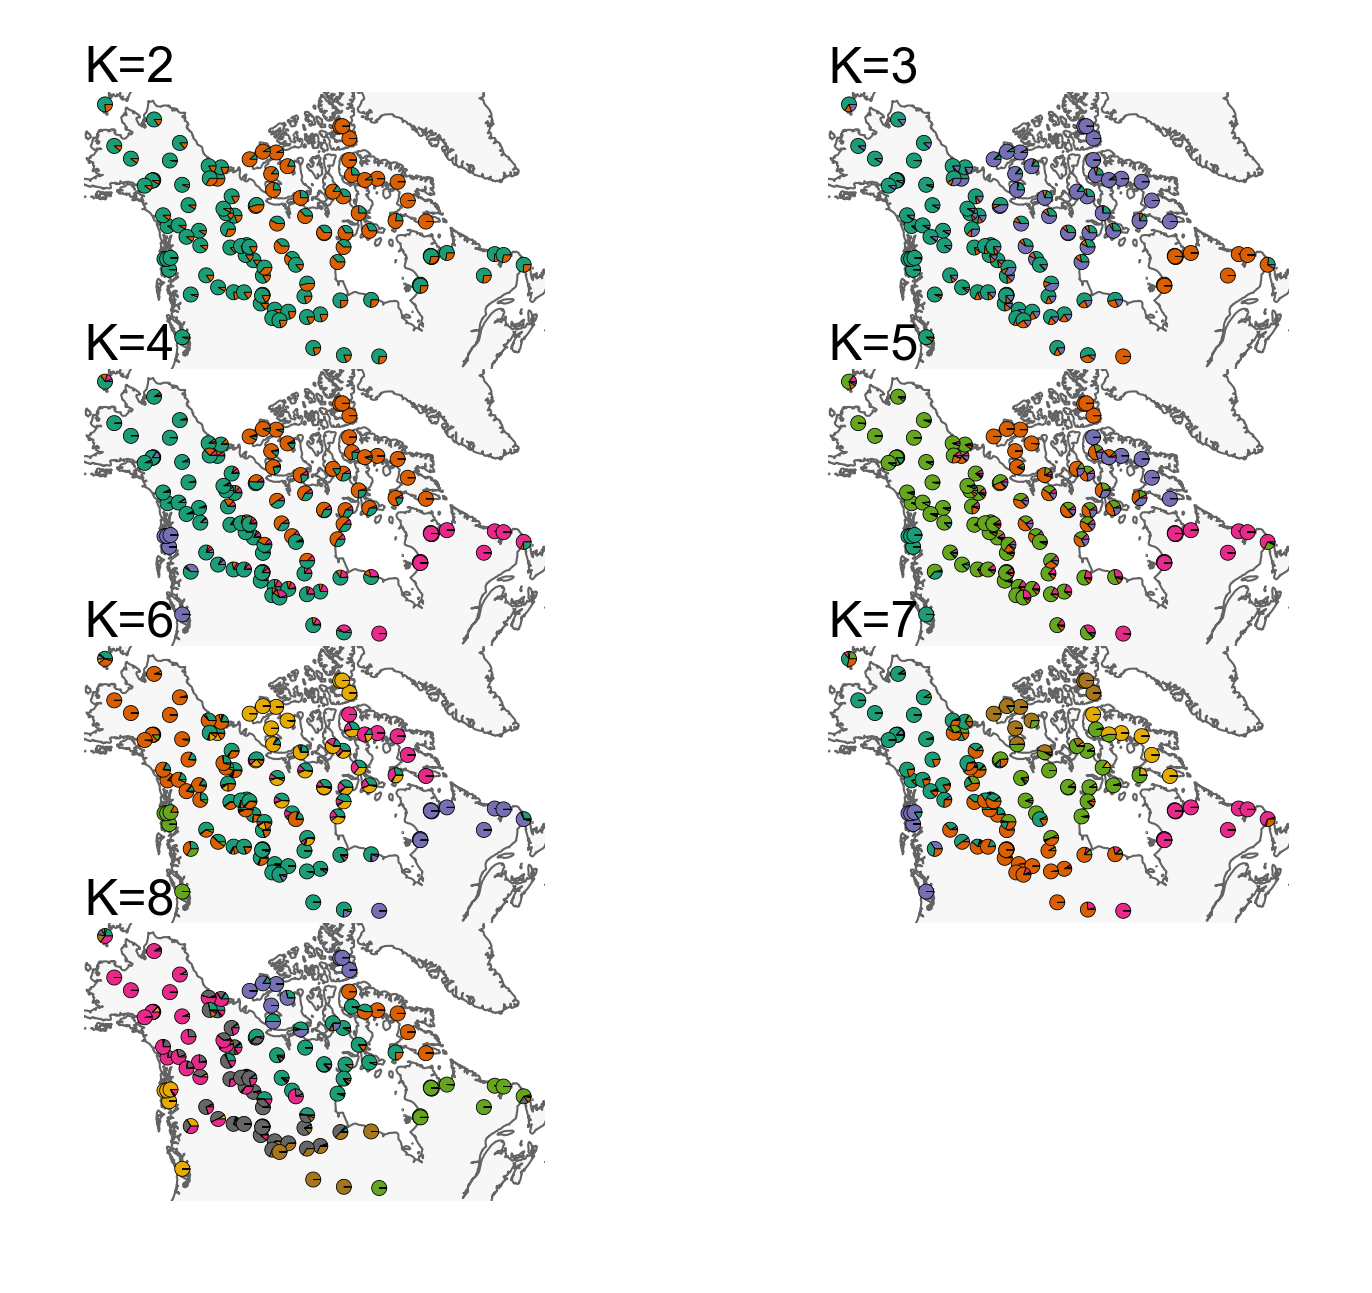

In [133]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
n, p = wolves_graph.genotypes.shape
radius = 0.125; title_pad = -10; title_loc = "left"
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig, wspace=0.0, hspace=0.0)

#################### axis 00 ####################
ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
ax_00.set_title("K=2", loc=title_loc, pad=title_pad)
v = Viz(ax_00, wolves_graph, projection=projection)
v.draw_map(latlong=False)
ax_00.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0.0)
for i in range(n):
    draw_admix_pie(Q_k2[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k2, 
                   radius=radius,
                   ax=ax_00)
    
#################### axis 01 ####################
ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
ax_01.set_title("K=3", loc=title_loc, pad=title_pad)
v = Viz(ax_01, wolves_graph, projection=projection)
v.draw_map(latlong=False)
ax_01.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k3[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k3, 
                   radius=radius,
                   ax=ax_01)

#################### axis 10 ####################
ax_10 = fig.add_subplot(spec[1, 0], projection=projection)
ax_10.set_title("K=4", loc=title_loc, pad=title_pad)
v = Viz(ax_10, wolves_graph, projection=projection)
v.draw_map(latlong=False)
ax_10.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k4[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k4, 
                   radius=radius,
                   ax=ax_10)

#################### axis 11 ####################
ax_11 = fig.add_subplot(spec[1, 1], projection=projection)
ax_11.set_title("K=5", loc=title_loc, pad=title_pad)
v = Viz(ax_11, wolves_graph, projection=projection)
v.draw_map(latlong=False)
ax_11.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k5[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k5, 
                   radius=radius,
                   ax=ax_11)

#################### axis 20 ####################
ax_20 = fig.add_subplot(spec[2, 0], projection=projection)
ax_20.set_title("K=6", loc=title_loc, pad=title_pad)
v = Viz(ax_20, wolves_graph, projection=projection)
v.draw_map(latlong=False)
ax_20.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k6[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k6, 
                   radius=radius,
                   ax=ax_20)

#################### axis 21 ####################
ax_21 = fig.add_subplot(spec[2, 1], projection=projection)
ax_21.set_title("K=7", loc=title_loc, pad=title_pad)
v = Viz(ax_21, wolves_graph, projection=projection)
v.draw_map(latlong=False)
ax_21.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k7[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k7, 
                   radius=radius,
                   ax=ax_21)

#################### axis 30 ####################
ax_30 = fig.add_subplot(spec[3, 0], projection=projection)
ax_30.set_title("K=8", loc=title_loc, pad=title_pad)
v = Viz(ax_30, wolves_graph, projection=projection)
v.draw_map(latlong=False)
ax_30.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k8[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k8, 
                   radius=radius,
                   ax=ax_30)
fig.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/wolves_admixK28.pdf')

In [96]:
# obj = Objective(wolves_graph)
# obj.inv()
# obj.grad(reg=False)
# obj.Linv_diag = np.diag(sp.linalg.pinvh(wolves_graph.L.todense()))

In [99]:
def exponential_variogram(h, nugget, sill, rangep):
    return nugget + sill * (1 - np.exp(-h / rangep))

def fit_variogram(distances, values):
    def objective(params):
        nugget, sill, rangep = params
        h = distances.flatten()
        gamma = 0.5 * np.power(values[:, None] - values[None, :], 2).flatten()
        var_model = exponential_variogram(h, nugget, sill, rangep)
        return np.sum((gamma - var_model)**2)
    
    result = sp.optimize.minimize(objective, [0, np.var(values), np.mean(distances)], method='L-BFGS-B', bounds=((0, None), (0, None), (0, None)))
    return result.x

def distance_kriging(observed_values, distances_to_observed, distances_between_observed):
    n_observed = len(observed_values)
    n_target = distances_to_observed.shape[0]
    
    # Fit variogram
    nugget, sill, rangep = fit_variogram(distances_between_observed, observed_values)
    print(nugget, sill, rangep)
    
    # Construct kriging matrices
    K = exponential_variogram(distances_between_observed, nugget, sill, rangep)
    K = K + 1e-8 * np.eye(n_observed)  # Add small value to diagonal for numerical stability
    k = exponential_variogram(distances_to_observed, nugget, sill, rangep)

    # Add a column of ones to K and k for the lagrange multiplier
    K = np.column_stack((K, np.ones(n_observed)))
    K = np.row_stack((K, np.ones(n_observed + 1)))
    K[-1, -1] = 0
    k = np.column_stack((k, np.ones((n_target, 1))))
    
    # Solve kriging equation
    weights = np.linalg.solve(K, k.T)
    
    # Perform interpolation
    interpolated_values = np.dot(weights[:-1, :].T, observed_values)
    
    return interpolated_values


qdf.iloc[94:,1] = distance_kriging(1/wolves_graph.q, 
                                   -2 * obj.Linv[wolves_graph.n_observed_nodes:, :wolves_graph.n_observed_nodes] + obj.Linv[:wolves_graph.n_observed_nodes, :wolves_graph.n_observed_nodes].diagonal() + obj.Linv_diag[wolves_graph.n_observed_nodes:, np.newaxis],
                                   -2*obj.Linv[:wolves_graph.n_observed_nodes, :wolves_graph.n_observed_nodes] + np.broadcast_to(np.diag(obj.Linv),(wolves_graph.n_observed_nodes, wolves_graph.n_observed_nodes)).T + np.broadcast_to(np.diag(obj.Linv), (wolves_graph.n_observed_nodes, wolves_graph.n_observed_nodes)))

0.0 0.04264966032821708 0.44373096626666114


In [98]:
permuted_idx = query_node_attributes(wolves_graph, "permuted_idx")
qdf = pd.DataFrame(columns=['loc','q'],index=range(1207))
# Rmat = -2*obj.Linv[:obj.sp_graph.n_observed_nodes,:obj.sp_graph.n_observed_nodes] + np.broadcast_to(np.diag(obj.Linv),(obj.sp_graph.n_observed_nodes,obj.sp_graph.n_observed_nodes)).T + np.broadcast_to(np.diag(obj.Linv),(obj.sp_graph.n_observed_nodes,obj.sp_graph.n_observed_nodes))
# rsm = np.mean(Rmat[np.tril_indices(obj.sp_graph.n_observed_nodes, k=-1)])
# rsd = np.std(Rmat[np.tril_indices(obj.sp_graph.n_observed_nodes, k=-1)])
# for i in range(1207):
#     qdf.iat[i,0] = permuted_idx[i]
#     if i < wolves_graph.n_observed_nodes:
#         qdf.iat[i,1] = 1/wolves_graph.q[i]
#     else:
#         R1 = np.array(-2*obj.Lpinv[:obj.sp_graph.n_observed_nodes,i].T + np.diag(obj.Linv) + obj.Lpinv[i,i])
        
#         # qdf.iat[i,1] = np.ravel(np.dot(1/wolves_graph.q, np.exp(-R1.T)))[0] # -> produces egregiously high values
#         # qdf.iat[i,1] = 1/wolves_graph.q[np.argmin(R1)]*np.exp(-2*np.min(R1))
#         # qdf.iat[i,1] = np.ravel(np.dot(1/wolves_graph.q, (1/R1.T)/np.sum(1/R1)))[0] #-> using dist. to all sampled demes
#         # topidx = np.argsort(R1)[0,:1] 
#         # qdf.iat[i,1] = np.ravel(np.dot(1/wolves_graph.q[topidx], (1/R1[0,topidx].T)/np.sum((1/R1[0,topidx]))))[0]
#         qdf.iat[i,1] = np.ravel(np.dot(1/wolves_graph.q, 1/R1[0,:]*np.exp(-0.25*np.abs(rsm-R1[0,:])/rsd)/np.sum(1/R1[0,:]*np.exp(-0.25*np.abs(rsm-R1[0,:])/rsd))))[0]
#         # qdf.iat[i,1] = 1/wolves_graph.q[np.argmin(R1)]

## computing resmat for an unsampled source and comparing to resmat from a sampled source
# Rmat = -2*obj.Linv[:94,:94] + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((wolves_graph.n_observed_nodes,1)).T + np.ones((wolves_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
# Q1mat = np.ones((wolves_graph.n_observed_nodes,1)) @ wolves_graph.q_inv_diag.diagonal().reshape(1,-1)
# resmat = Rmat + (Q1mat + Q1mat.T) - 2*wolves_graph.q_inv_diag

# resmatc = deepcopy(resmat); c = 0.5

# lrn = [(66,89)]

# resmatc[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/wolves_graph.q[lrn[0][0]] + (1-c)/wolves_graph.q[lrn[0][1]]
# resmatc[lrn[0][1],lrn[0][0]] = resmatc[lrn[0][0],lrn[0][1]]

# ## id
# for i in set(range(wolves_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
#     resmatc[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/wolves_graph.q[i] + (1-c)/wolves_graph.q[lrn[0][1]] + c/wolves_graph.q[lrn[0][0]]
#     resmatc[lrn[0][1],i] = resmatc[i,lrn[0][1]]

# resmat1 = deepcopy(resmat); c = 0.5

# lrn = [(673,89)]

# R1d = -2*obj.Linv[lrn[0][0],lrn[0][1]] + obj.Lpinv[lrn[0][0],lrn[0][0]] + obj.Linv[lrn[0][1],lrn[0][1]]
# R1 = -2*obj.Lpinv[:obj.sp_graph.n_observed_nodes,lrn[0][0]].T + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]]
# one = np.argmin(R1)
# resmat1[one,lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[one,lrn[0][1]] + (1-c)/obj.sp_graph.q[lrn[0][1]] + (1+c)*np.ravel(np.dot(1/wolves_graph.q, (1/R1.T)/np.sum(1/R1)))[0] 
# resmat1[lrn[0][1],one] = resmat1[one,lrn[0][1]]

# R1 = -2*obj.Lpinv[:obj.sp_graph.n_observed_nodes,lrn[0][0]].T + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]]
# topidx = np.ravel(np.argsort(R1[0,:])[0,:1]).tolist()
# q1 = np.dot(1/obj.sp_graph.q[topidx], (1/R1[0,topidx].T)/np.sum(1/R1[0,topidx]))

# for it in topidx:
#         resmat1[it,lrn[0][1]] = Rmat[it,lrn[0][1]] + 0.5*(c**2-c)*R1[0,lrn[0][1]] + (1+c)/obj.sp_graph.q[lrn[0][1]] - c*q1 + 1/obj.sp_graph.q[it]
#         resmat1[lrn[0][1],it] = resmat1[it,lrn[0][1]]   
# for i in set(range(obj.sp_graph.n_observed_nodes))-set(topidx+[lrn[0][1]]):
#         resmat1[i,lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[i,lrn[0][1]] + (1+c)/obj.sp_graph.q[i] + (1-c)/obj.sp_graph.q[lrn[0][1]]
#         # resmat1[i,lrn[0][1]] = (1-c)*Rmat[i,lrn[0][1]] + c*R1[0,i] + 0.5*(c**2-c)*R1[0,lrn[0][1]] + 1/obj.sp_graph.q[i] + (1-c)/obj.sp_graph.q[lrn[0][1]] + c*q1
#         resmat1[lrn[0][1],i] = resmat1[i,lrn[0][1]]

# resmat1[one,lrn[0][1]] = (1-c)*Rmat[one,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1+c)/obj.sp_graph.q[lrn[0][1]] + (1-c)/obj.sp_graph.q[one] 
# resmat1[one,lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[one,lrn[0][1]] + (1-c)/obj.sp_graph.q[lrn[0][1]] + (1+c)/obj.sp_graph.q[one]

# for i in set(range(obj.sp_graph.n_observed_nodes))-set([lrn[0][1]]):
#         resmat1[i,lrn[0][1]] = (1-c)*Rmat[i,lrn[0][1]] + c*Rmat[i,one] + 0.5*(c**2-c)*R1d + 1/obj.sp_graph.q[i] + (1-c)/obj.sp_graph.q[lrn[0][1]] + c/obj.sp_graph.q[one]
#         resmat1[lrn[0][1],i] = resmat1[i,lrn[0][1]]

# plt.imshow(resmatc-resmat1,cmap='RdBu'); plt.colorbar()
# resmatc[72,89], resmat1[72,89]

# D = np.ones(obj.sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(obj.sp_graph.S).reshape(1,-1) + np.diag(obj.sp_graph.S).reshape(-1,1) @ np.ones(obj.sp_graph.n_observed_nodes).reshape(1,-1) - 2*obj.sp_graph.S

# -sp.stats.wishart.logpdf(-obj.sp_graph.n_snps*obj.C @ D @ obj.C.T, obj.sp_graph.n_snps, -obj.C @ resmatc @ obj.C.T), -sp.stats.wishart.logpdf(-obj.sp_graph.n_snps*obj.C @ D @ obj.C.T, obj.sp_graph.n_snps, -obj.C @ resmat1 @ obj.C.T)

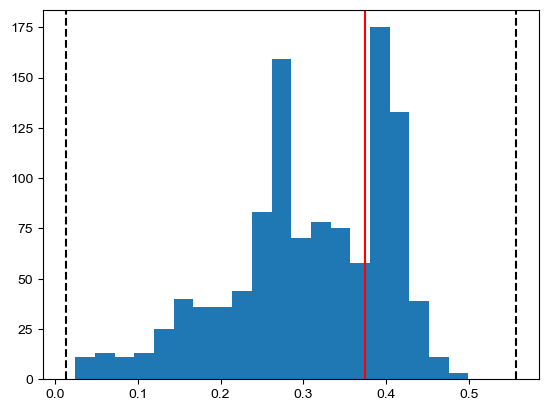

In [100]:
# obj.neg_log_lik_c(0.5,{'lre':[(741,89)],'mode':'unsampled'})
# (1/R1[0,70].T)/np.sum(1/R1[0,topidx])
# lrn = [(741,89)]
# set([(np.ravel(topidx.tolist())),lrn[0][1]])
# R1 = -2*obj.Lpinv[lrn[0][0],:obj.sp_graph.n_observed_nodes] + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]]
# R1 = -2*obj.Lpinv[:obj.sp_graph.n_observed_nodes,lrn[0][0]].T + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]]
# topidx = np.ravel(np.argsort(R1[0,:])[0,:1]).tolist()
# plt.plot(np.linspace(0,2,20),3.2*np.exp(-0.5*np.linspace(0,2,20)),color=plt.get_cmap('Blues',4)(1),label='0.5')
# plt.plot(np.linspace(0,2,20),3.2*np.exp(-np.linspace(0,2,20)),color=plt.get_cmap('Blues',4)(2),label='1')
# plt.plot(np.linspace(0,2,20),3.2*np.exp(-2*np.linspace(0,2,20)),color=plt.get_cmap('Blues',4)(3),label='2')
# plt.legend(title=r'$\lambda$')
# np.dot(1/wolves_graph.q,np.exp(-R1.T))
# np.dot(1/wolves_graph.q[:3],np.exp(-2*R1[0,:3]).T)
# np.argsort(R1)[0,:1], np.argmin(R1)
plt.hist(np.ravel(qdf['q'].iloc[94:]),bins=20); plt.axvline(np.min(1/wolves_graph.q),color='k',ls='--'); plt.axvline(np.max(1/wolves_graph.q),color='k',ls='--')
plt.axvline(np.median(1/wolves_graph.q),color='red')

In [ ]:
for lw in [2., 0.02]:
    for lq in [10., 1.]:
        wolves_graph.fit(lamb=lw,optimize_q='n-dim',lamb_q=lq)
        obj = FEEMSmix_Objective(wolves_graph); obj.inv(); obj.grad(reg=False)
        status = False
        outliers_df = obj.extract_outliers(0.25, verbose=True)
        if len(outliers_df) == 0:
            status = True
            outliers_df = obj.extract_outliers(0.5, verbose=True)
        fig = plt.figure(dpi=200)
        projection = ccrs.AzimuthalEquidistant(central_longitude=-100, central_latitude=60)  
        ax = fig.add_subplot(1, 1, 1, projection=projection)  
        v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=4, cbar_font_size=10, cbar_ticklabelsize=8)
        v.draw_map(latlong=False); v.draw_obs_nodes(use_ids=False); v.draw_edges(use_weights=True); v.draw_edge_colorbar()
        if status:
            v.ax.set_title(r'$\lambda={:.2f}, \lambda_q = {:.1f}, FDR = 0.5$'.format(lw, lq))
        else:
            v.ax.set_title(r'$\lambda={:.2f}, \lambda_q = {:.1f}, FDR = 0.25$'.format(lw, lq))
        for i in range(outliers_df.shape[0]):
            v.ax.plot([v.grid[outliers_df['source'].iloc[i],0],v.grid[outliers_df['dest.'].iloc[i],0]],[v.grid[outliers_df['source'].iloc[i],1],v.grid[outliers_df['dest.'].iloc[i],1]],linewidth=0.4,color='grey')
        for dest in np.unique(outliers_df['dest.']):
            v.ax.plot(v.grid[dest, 0], v.grid[dest, 1], 'o', color='dodgerblue', markersize=20*np.log10(np.sum(outliers_df['dest.']==dest)+1), alpha=0.5)
        fit_cov, _, emp_cov = comp_mats(obj)
        fit_dist = cov_to_dist(fit_cov)[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]
        emp_dist = cov_to_dist(emp_cov)[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]
        X = sm.add_constant(fit_dist)
        mod = sm.OLS(emp_dist, X)
        res = mod.fit()
        muhat, betahat = res.params
        plt.figure(2)
        plt.plot(fit_dist, emp_dist, 'o', color='grey', alpha=0.5, markersize=4); plt.axline((0,muhat), slope=betahat, color='orange', ls='--', lw=3)
        plt.text(2, 0.5, "R²={:.3f}".format(res.rsquared), fontsize=15); plt.xlabel('fit distance'); plt.ylabel('empirical distance'); plt.grid(); plt.box(False); plt.show()

  Optimizing likelihood over 1040 demes in the graph...25%...50%...75%...done!
CPU times: user 2min 38s, sys: 11.7 s, total: 2min 49s
Wall time: 51.3 s


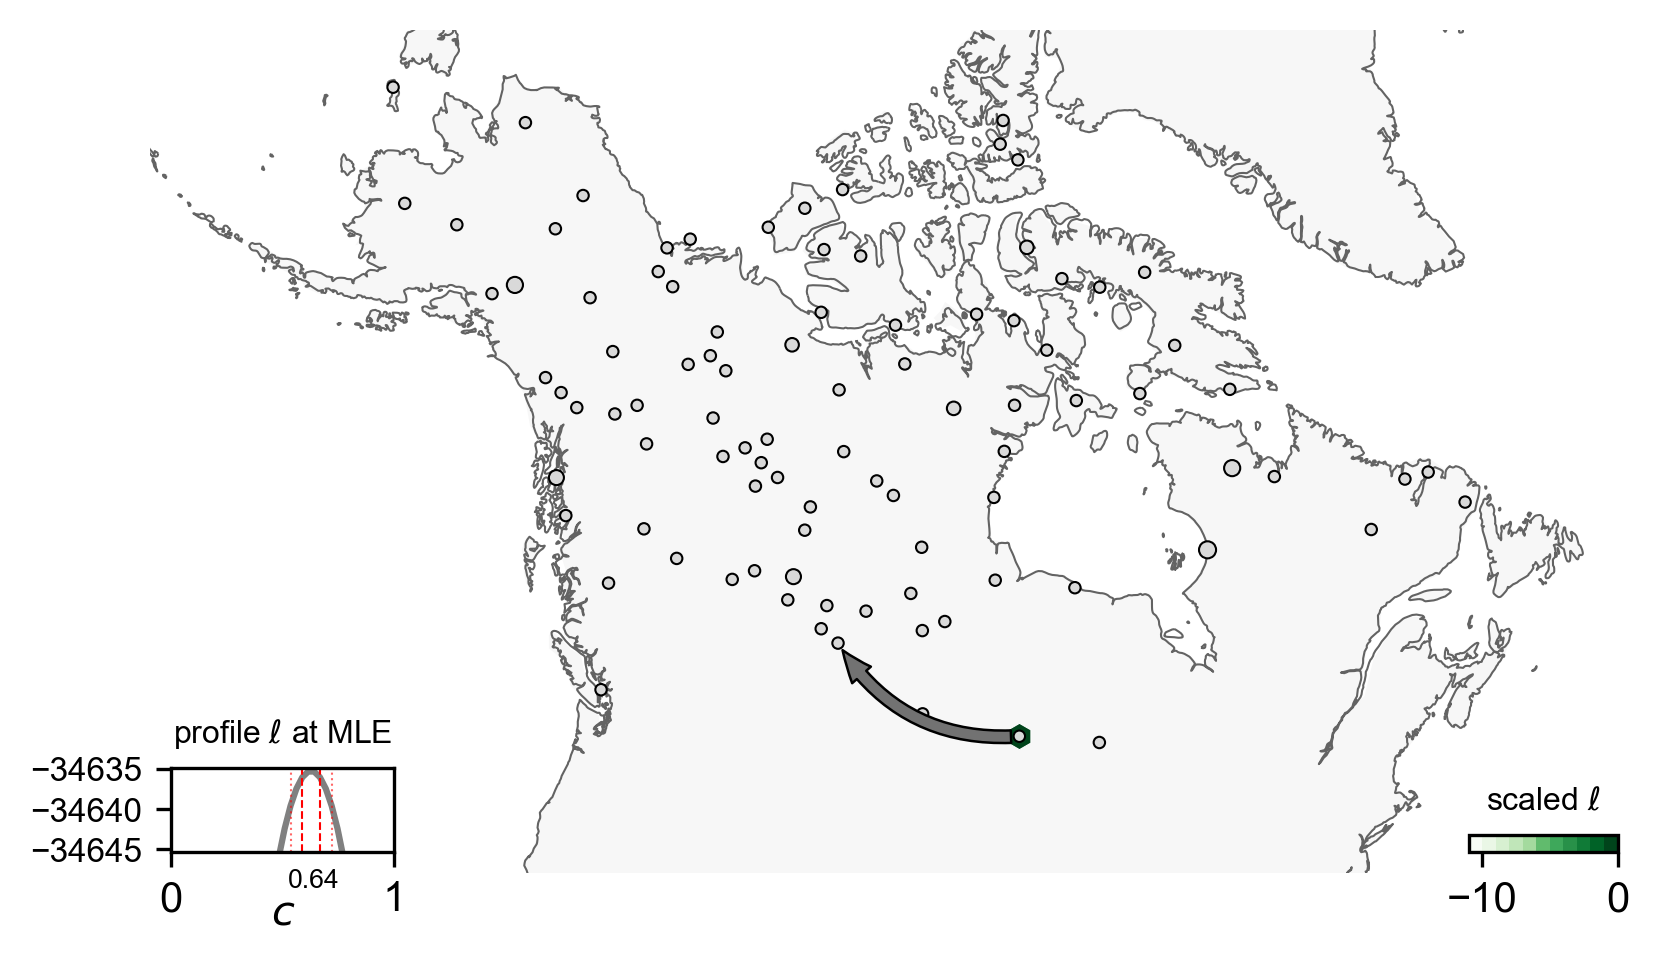

In [501]:
%time contour_df980 = wolves_graph.calc_contour(destid=815, search_area='all', exclude_boundary=True)
# joint_contour_df980 = wolves_graph.calc_joint_contour(contour_df=contour_df980, top=50, lamb=2., lamb_q=1.)
# contour_df980 = contour_df980.drop(np.where(np.isnan(contour_df980['scaled log-lik']))[0]+1)
# contour_dict[980] = contour_dict[980].drop(np.where(np.isnan(contour_dict[980]['scaled log-lik']))[0]+1)

# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
# v.draw_map(latlong=False); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=True); v.draw_edge_colorbar()
# v.draw_c_contour(contour_df980,levels=1,ll_thresh=-3)
# v.ax.plot(obs_grid[np.where(permuted_idx == 980)[0], 0], obs_grid[np.where(permuted_idx == 980)[0], 1], 'ro', markersize=10, alpha=0.5)

# e = 980
# import cartopy.feature as cfeature
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection);  ax.set_extent([-145, -60, 35, 80])
v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5, obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
v.draw_map(latlong=False); #v.draw_het()
# v.ax.add_feature(cfeature.BORDERS, color='grey', zorder=0)
# v.ax.add_feature(cfeature.NaturalEarthFeature(
#     category='cultural',
#     name='admin_1_states_provinces_lines',
#     scale='50m', linestyle=':', edgecolor='k', facecolor='white'), zorder=0)
# v.draw_arrow([(742,980)],0.4)
v.draw_loglik_contour(contour_df980,loglik_node_size=20,magnifier=200,levels=-10,); v.draw_obs_nodes(use_ids=False)
# pe = contour_dict[e]['(source, dest.)'].iloc[np.argmax(contour_dict[e]['scaled log-lik'])]
# v.draw_arrow([(np.where(permuted_idx==pe[0])[0][0],pe[1])],1.,lw=1.66,hw=0.8e5,hl=.8e5,mode='unsampled',fs=0)
# v.draw_arrow([(np.where(permuted_idx==pe[0])[0][0],pe[1])],contour_dict[e]['admix. prop.'].iloc[np.argmax(contour_dict[e]['scaled log-lik'])],lw=.5,hw=.8e5,hl=.8e5,mode='unsampled',fs=2)
# v.draw_arrow([(46,89)],1.,lw=1.66,hw=0.8e5,hl=.8e5,mode='sampled',fs=0)
# v.draw_arrow([(46,89)],0.38,lw=.5,hw=.8e5,hl=.8e5,mode='sampled',fs=10)

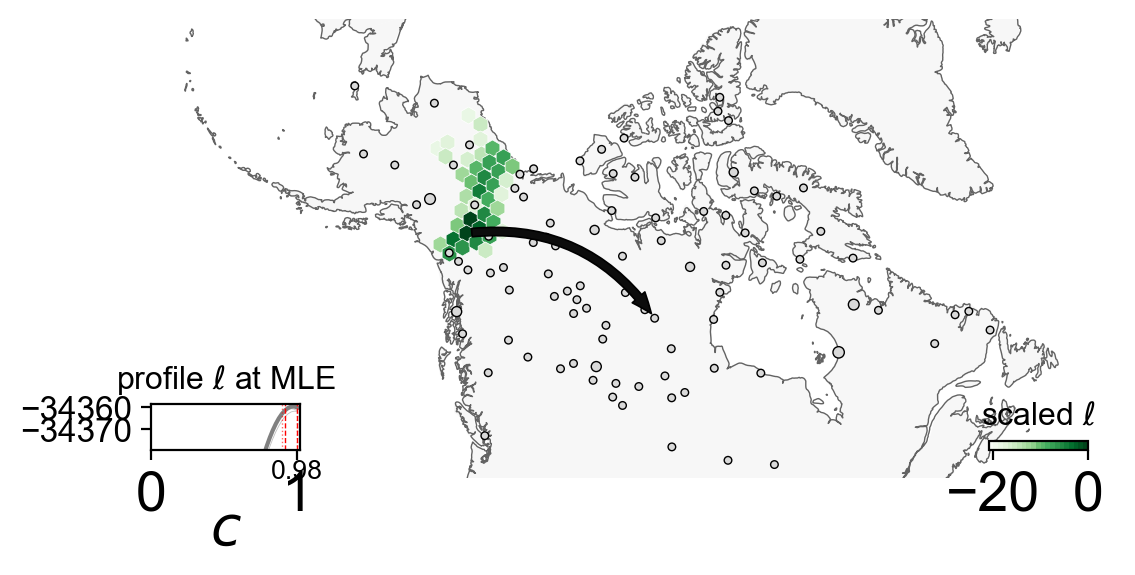

In [743]:
# contour_df621 = obj.calc_contour(destpid=621, search_area='range', opts=[[-115,-180],[40,80]])  
# contour_df621 = wolves_graph.calc_contour(destid=621, search_area='all')

# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
# v.draw_map(latlong=False); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# v.draw_c_contour(contour_df621,levels=[0,0.1,0.25,0.5,1])
# v.ax.plot(obs_grid[np.where(permuted_idx == 621)[0], 0], obs_grid[np.where(permuted_idx == 621)[0], 1], 'ro', markersize=10, alpha=0.5)

# e = 621
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection);  ax.set_extent([-160, -55, 37, 80])
v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
        obs_node_size=7.5, sample_pt_color="black")
v.draw_map(latlong=False); 
# v.draw_arrow([contour_df621['(source, dest.)'].iloc[np.argmax(contour_df621['scaled log-lik'])]],0.9)
v.draw_loglik_contour(contour_df621,levels=-20); v.draw_obs_nodes(use_ids=False); 
# pe = contour_dict[e]['(source, dest.)'].iloc[np.argmax(contour_dict[e]['scaled log-lik'])]
# v.draw_arrow([(np.where(permuted_idx==pe[0])[0][0],pe[1])],1.,lw=1.66,hw=0.8e5,hl=.8e5,mode='unsampled',fs=0)
# v.draw_arrow([(np.where(permuted_idx==pe[0])[0][0],pe[1])],contour_dict[e]['admix. prop.'].iloc[np.argmax(contour_dict[e]['scaled log-lik'])],lw=.5,hw=.8e5,hl=.8e5,mode='unsampled',fs=2)

In [734]:
# contour_df585.iloc[np.argmax(contour_df585['scaled log-lik'])]
wolves_graph.nodes[229]

{'idx': 229,
 'pos': array([-138.63 ,   62.749]),
 'n_samples': 0,
 'sample_idx': [],
 'permuted_idx': 142}

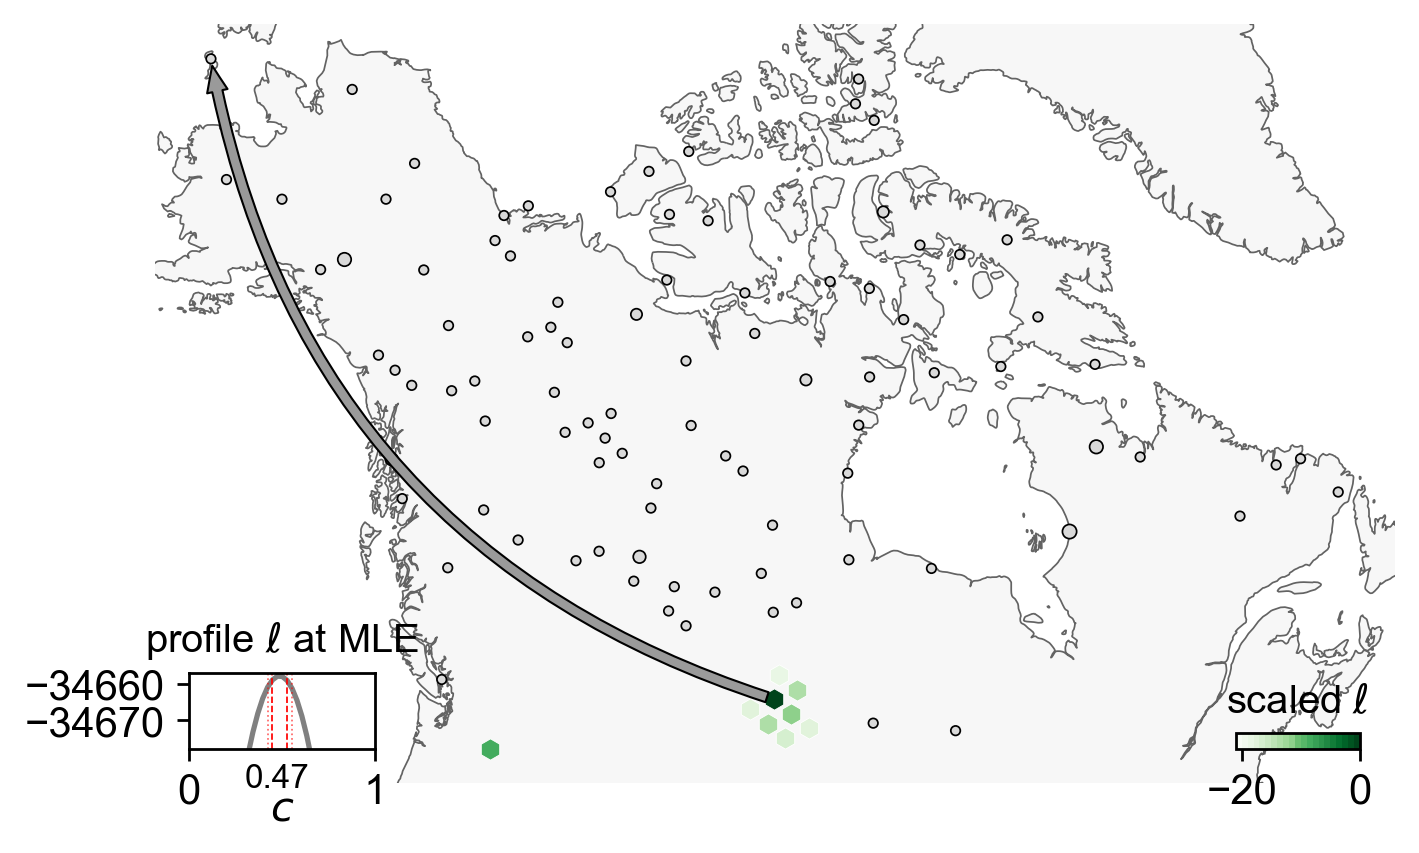

In [778]:
# contour_df1206 = wolves_graph.calc_contour(destid=1206, search_area='range', opts=[[-60,-115],[50,70]])
# contour_df1206 = contour_df1206.drop(np.where(np.isnan(contour_df1206['scaled log-lik']))[0]+1)
# contour_dict[1206] = contour_df1206

e = 1206
fig = plt.figure(dpi=250)
ax = fig.add_subplot(1, 1, 1, projection=projection)
v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,obs_node_size=7.5, sample_pt_color="black")
v.draw_map(latlong=False); v.draw_obs_nodes(use_ids=False); #v.draw_edges(use_weights=True); v.draw_edge_colorbar()
v.draw_loglik_contour(contour_dict[1206],levels=-20)
# pe = contour_dict[e]['(source, dest.)'].iloc[np.argmax(contour_dict[e]['scaled log-lik'])]
# v.draw_arrow([(np.where(permuted_idx==pe[0])[0][0],93)],1.,lw=1.66,hw=0.8e5,hl=.8e5,mode='unsampled',fs=0)
# v.draw_arrow([(np.where(permuted_idx==pe[0])[0][0],93)],contour_dict[e]['admix. prop.'].iloc[np.argmax(contour_dict[e]['scaled log-lik'])],lw=.5,hw=.8e5,hl=.8e5,mode='unsampled',fs=2)

In [48]:
# import networkx as nx
# sample_idx = nx.get_node_attributes(wolves_graph, "sample_idx")
# permuted_idx = query_node_attributes(wolves_graph, "permuted_idx")
# observed_permuted_idx = permuted_idx[: wolves_graph.n_observed_nodes]

# freqs = np.zeros_like(wolves_graph.frequencies)
# for i, node_id in enumerate(observed_permuted_idx):
#     s = sample_idx[node_id]

#     # compute mean at each node
#     freqs[i,:] = np.mean(wolves_graph.genotypes[s,:], axis=0)/2

# het = 2*freqs*(1-freqs)

# plt.plot(np.arange(1,wolves_graph.n_observed_nodes+1),het.mean(axis=1),'ko'); plt.axhline(het.mean(),color='red',linestyle='--'); plt.xlabel('deme ID'); plt.ylabel('average heterozygosity'); plt.grid()

## Rerunning FEEMSmix with a None fit 

In [946]:
# wolves_graph.fit(lamb=2., optimize_q=None, lamb_q=0)

# obj = FEEMSmix_Objective(wolves_graph); obj.inv(); obj.Lpinv = np.linalg.pinv(wolves_graph.L.todense()); obj.grad(reg=False)

odf = wolves_graph.extract_outliers(0.25, verbose=False)

Using a FDR of 0.25: 61 outlier deme pairs found
Putative destination demes: [ 250  223  632  668  185  438  189  440 1124  370  402  240  267  569
  621  690  719  737  129  445  350  339  197  187  180  521 1206]


In [954]:
# Arc = mpatches.Patch(color='#1B9E77', label='Arctic')
# HA = mpatches.Patch(color='#66A61E', label='HighArctic')
np.sum(odf['dest.'].isin(poporder['id'].loc[poporder['col'].isin(['#66A61E','#1B9E77'])]))

45

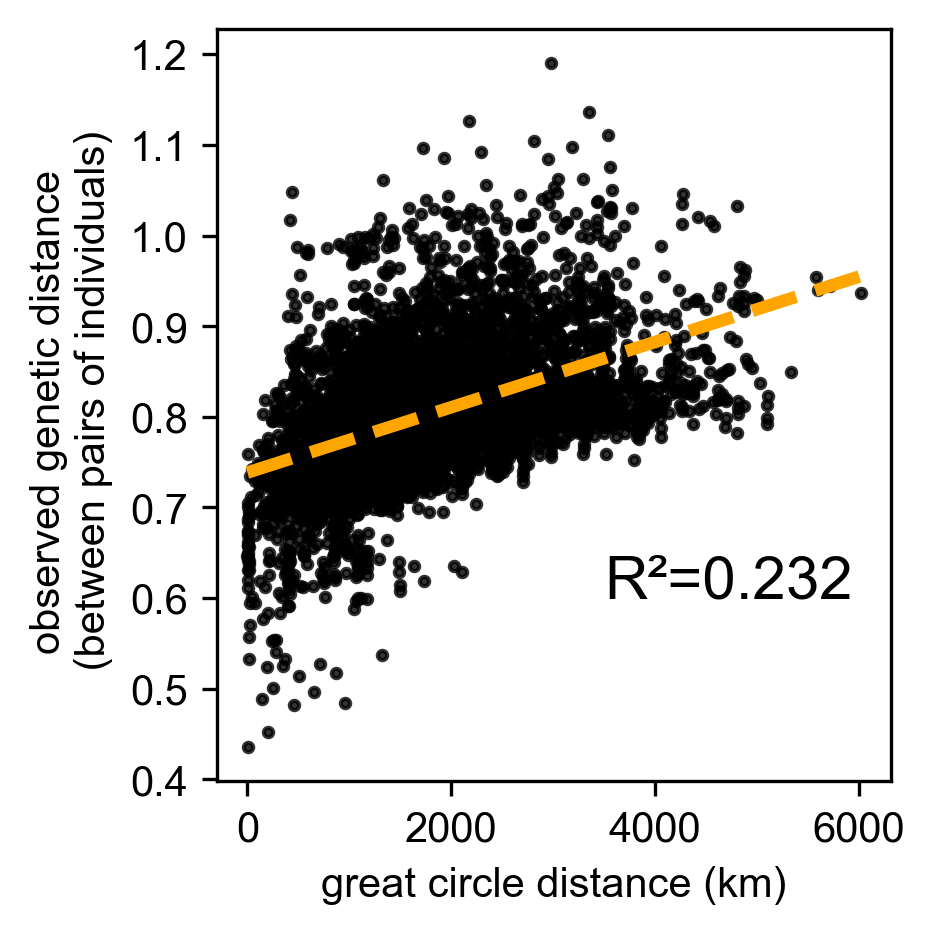

In [50]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, dpi=300, figsize=(3, 3), sharey=True)
D_geno = squareform(pdist(genotypes, metric="sqeuclidean")) / np.shape(wolves_graph.genotypes)[1]
coord_rad = coord[:,::-1] * np.pi / 180.0
D_geo = haversine_distances(coord_rad) * 6371000/1000
tril_idx = np.tril_indices(np.shape(wolves_graph.genotypes)[0], k=-1)
x = D_geo[tril_idx]
y = D_geno[tril_idx]
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params

axs.scatter(x, y, marker=".", alpha=0.8, zorder=0, color="k", s=20)
x_ = np.linspace(np.min(x), np.max(x), 20)
axs.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=3)
axs.text(3500, .6, "R²={:.3f}".format(res.rsquared), fontsize='x-large')
axs.set_xlabel("great circle distance (km)")
axs.set_ylabel("observed genetic distance \n (between pairs of individuals)"); 

In [71]:
def get_resmat_mult(c, sp_graph, obj, lrn, mode):
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.broadcast_to(np.diag(obj.Linv),(o,o)).T + np.broadcast_to(np.diag(obj.Linv),(o,o)) #np.reshape(np.diag(obj.Linv[:o,:o]),(-1,1)) @ np.ones((1,sp_graph.n_observed_nodes)) + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = np.broadcast_to(sp_graph.q_inv_diag.diagonal(),(o,o)) #np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag     

    for ic, ct in enumerate(c):
        if mode[ic]=='sampled':
            resmat[lrn[ic][0],lrn[ic][1]] = (0.5*ct**2-1.5*ct+1)*Rmat[lrn[ic][0],lrn[ic][1]] + (1+ct)/sp_graph.q[lrn[ic][0]] + (1-ct)/sp_graph.q[lrn[ic][1]]
            resmat[lrn[ic][1],lrn[ic][0]] = resmat[lrn[ic][0],lrn[ic][1]]

            ## id
            for i in set(range(sp_graph.n_observed_nodes))-set([lrn[ic][0],lrn[ic][1]]):
                resmat[i,lrn[ic][1]] = (1-ct)*(Rmat[i,lrn[ic][1]]) + ct*Rmat[i,lrn[ic][0]] + 0.5*(ct**2-ct)*Rmat[lrn[ic][0],lrn[ic][1]] + 1/sp_graph.q[i] + (1-ct)/sp_graph.q[lrn[ic][1]] + ct/sp_graph.q[lrn[ic][0]]
                resmat[lrn[ic][1],i] = resmat[i,lrn[ic][1]]
        else:
            neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
                # finds the neighboring deme that has samples
            neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]
    
            R1d = -2*obj.Linv[lrn[ic][0],lrn[ic][1]] + obj.Linv_diag[lrn[ic][0]] + obj.Linv[lrn[ic][1],lrn[ic][1]]
            R1 = np.array(-2*obj.Linv[lrn[ic][0],:sp_graph.n_observed_nodes].T + np.diag(obj.Linv) + obj.Linv_diag[lrn[ic][0]])
    
            # apply this formula only to neighboring sampled demes
            for n in neighs:
                # convert back to appropriate indexing excluding the unsampled demes
                s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==n][0]
                # (1+c)q_s gives an overestimate of the c value (slide 61) ->  keeping it at 1-c
                resmat[s,lrn[ic][1]] = Rmat[s,lrn[ic][1]] + 0.5*(ct**2-ct)*R1d + (1-ct)/sp_graph.q[s] + (1+ct)/sp_graph.q[lrn[ic][1]]
                resmat[lrn[ic][1],s] = resmat[s,lrn[ic][1]]
    
            proxs = np.argsort([nx.shortest_path_length(sp_graph,source=lrn[ic][0],target=d) for d in set(sp_graph.perm_idx[:sp_graph.n_observed_nodes])-set([lrn[ic][0]])])[:sp_graph.n_observed_nodes]
            # qprox = np.dot(1/self.sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
            qprox = np.dot(1/sp_graph.q[proxs], (R1[proxs]*np.exp(-2*R1[proxs]))/np.sum(R1[proxs]*np.exp(-2*R1[proxs])))
            ## id
            for i in set(range(sp_graph.n_observed_nodes))-set([lrn[ic][0],lrn[ic][1]]+neighs):
                Ri1 = -2*obj.Linv[lrn[ic][0],i] + obj.Linv[i,i] + obj.Linv_diag[lrn[ic][0]]
                # resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/self.sp_graph.q[i] + (1-c)/self.sp_graph.q[opts  ['lre'][0][1]] + c/self.sp_graph.q[proxs]
                # should there be a (1+c)q_d here?
                resmat[i,lrn[ic][1]] = (1-ct)*Rmat[i,lrn[ic][1]] + ct*Ri1 + 0.5*(ct**2-ct)*R1d + 1/sp_graph.q[i] + (1-ct)/sp_graph.q[lrn[ic][1]] + ct*qprox
                resmat[lrn[ic][1],i] = resmat[i,lrn[ic][1]]
  
    return resmat

In [106]:
## try fitting 980, 207, 180 and then one or two more edges to squeeze out a few more percentage points
# norm = plt.Normalize(np.min(fit_dist),np.max(fit_dist))
obj = Objective(wolves_graph); obj.inv(); obj.grad(reg=False)
obj.Linv_diag = obj._comp_diag_pinv()
args = {}; args['mode']='update'; args['lre'] = [(711,89)]
args['delta'] = obj._compute_delta_matrix(0.4, args)
args['lre'] = [(860,93)]
args['delta'] = obj._compute_delta_matrix(0.4, args)
# args['lre'] = [(553,10)]
# args['delta'] = obj._compute_delta_matrix(0.2, args)
# args['lre'] = [(367,15)]
# args['delta'] = obj._compute_delta_matrix(0.2, args)
# contour_dict[207].loc[np.argmax(contour_dict[207]['scaled log-lik'])]

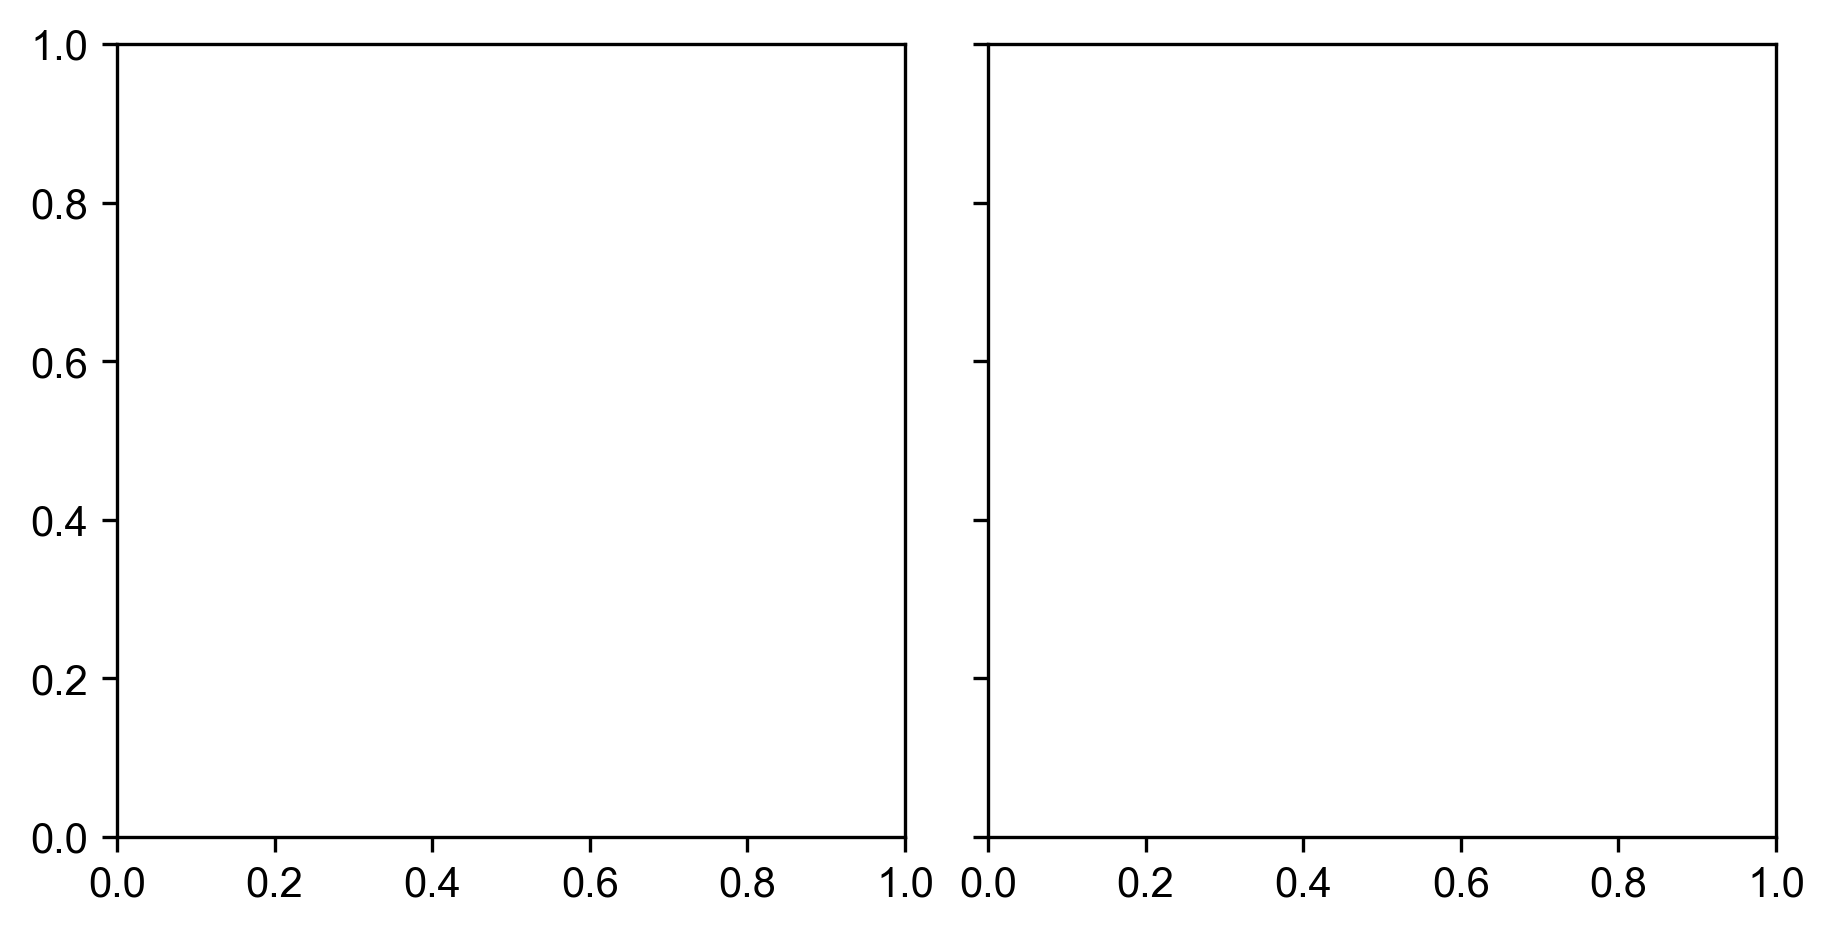

In [299]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, dpi=300, figsize=(6, 3), sharey=True)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]
emp_dist = cov_to_dist(emp_cov)[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params

bh = benjamini_hochberg(emp_dist, fit_dist, 0.1)
axs[0].scatter(fit_dist, emp_dist, marker='.', color='k', alpha=0.8, s=20); axs[0].set_ylabel('observed genetic distance\n(between pairs of demes)');
axs[0].axline((0.5,0.5*betahat+muhat), slope=betahat, color='orange', ls='--', lw=3)
for i in np.where(bh)[0]:
    axs[0].scatter(fit_dist[i], emp_dist[i], marker='x', color='red', alpha=0.8,linewidth=1); #plt.get_cmap('YlOrRd')(norm(fit_dist[i]))
# axs[0].plot(fit_dist[bh], emp_dist[bh], 'x', color=plt.get_cmap('YlOrRd')(norm(fit_dist[bh])), alpha=0.8, markersize=4); 
axs[0].text(0.8, 0.5, "R²={:.3f}".format(res.rsquared), fontsize=15); axs[0].set_xlabel(r'fitted $\tt{FEEMS}$ distance');

# resmat = get_resmat_mult([0.4,0.4,1,0.2,0.1,0.8,0.6,1,0.27,0.76,0.6,0.9], wolves_graph, obj, 
#                          [(860,93),(711,89),(553,10),(185,13),(250,37),(367,15),(367,59),(853,74),(630,12),(646,36),(1078,79),(229,63)], ['unsampled']*12)
# res_dist = resmat[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)].T
res_dist = np.array(cov_to_dist(-0.5*args['delta'])[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]).T
# res_dist = seq_results[2]['fit_dist']

X = sm.add_constant(res_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
for il in range(np.sum(bh)):
    axs[1].annotate(
        '',  # No text
        xytext=(res_dist[bh][il], emp_dist[bh][il]),  # Arrow end (head)
        xy=(fit_dist[bh][il], emp_dist[bh][il]),  # Arrow start (tail)
        arrowprops=dict(
            arrowstyle="<-",  # Arrow style
            color='r',  # Color of the arrow
            linewidth=0.7,  # Width of the arrow line
            alpha=0.9
        )
    )

axs[1].scatter(res_dist, emp_dist, marker='.', color='k', alpha=0.8, s=20); 
axs[1].axline((0.5,0.5*betahat+muhat), slope=betahat, color='orange', ls='--', lw=3)
axs[1].plot(res_dist[bh], emp_dist[bh], '.', color='r', alpha=0.8, markersize=2); 
axs[1].scatter(fit_dist[bh], emp_dist[bh], marker='x', color='r', alpha=0.8, linewidth=1); 
axs[1].text(0.8, 0.5, "R²={:.3f}".format(res.rsquared), fontsize=15); axs[1].set_xlabel(r'fitted $\tt{FEEMSmix}$ distance');

# plt.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/wolves_geo_gen.pdf')

In [221]:
# from skbio import DistanceMatrix
# from skbio.stats.distance import mantel

# mantel(D_geno, D_geo, method='spearman')
# np.sum(wolves_graph.n_samples_per_obs_node_permuted==1)/111
# wolves_graph.nodes[747]
# plt.figure(dpi=250)

NameError: name 'joint_contour_dist' is not defined

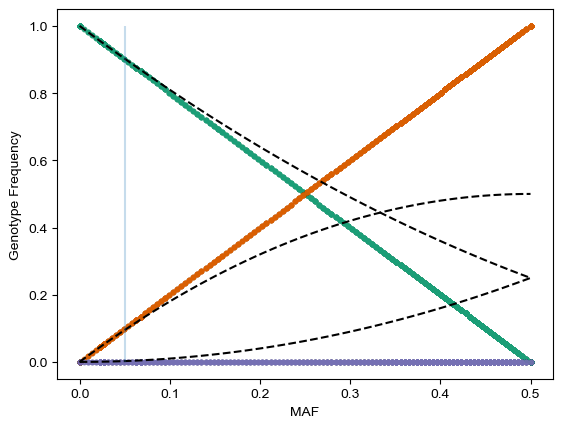

In [237]:
# Y = np.around(2 - 2*Q_k3@P_k3.T)
# Y = 2 - genotypes
n, p = Y.shape

f = np.nansum(Y, axis=0) / (2.0*n)
f_aa = np.nansum(Y==0, axis=0) / n
f_Aa = np.nansum(Y==1, axis=0) / n
f_AA = np.nansum(Y==2, axis=0) / n

x = np.linspace(0, .5)
plt.scatter(f, f_aa, alpha=.1, marker=".", color="#1b9e77", zorder=0)
plt.plot(x, (1-x)**2, "--", color="black", zorder=1) 
plt.scatter(f, f_Aa, alpha=.1, marker=".", color="#d95f02", zorder=0)
plt.plot(x, 2*x*(1-x), "--", color="black", zorder=1) 
plt.scatter(f, f_AA, alpha=.1, marker=".", color="#7570b3", zorder=0)
plt.plot(x, x**2, "--", color="black", zorder=1) 
plt.xlabel("MAF");
plt.ylabel("Genotype Frequency");
plt.vlines(ymin=0, ymax=1, x=.05, linestyles="-", alpha=.25)

## Removing the conflicting samples and rerunning the analyses

In [958]:
for e in [189, 621, 585, 747, 390, 815, 180, 207]:
    print(e, wolves_graph.nodes[e]['sample_idx'])

189 [75]
621 [16]
585 [21]
747 [45]
390 [7]
815 [53]
180 [94]
207 [82]


In [293]:
# for e in [980, 1206, 213, 129, 187, 336, 350, 402, 668]:
#     print(e, wolves_graph.nodes[e]['sample_idx'])
# np.savetxt('{}/wolvesadmix_corrected.coord'.format(data_path),coord_new)

In [288]:
# coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
# coord[75,] = [-119.5415, 73.2794]
# coord[16,] = [-126.0922, 67.0383]
# coord[21,] = [-122.6354, 65.1412]

# admixinds = np.array([7, 53, 94, 82])
# nonadmix_geno = genotypes[[i for i in range(111) if i not in admixinds],:]
# nonadmix_geno = np.delete(nonadmix_geno,np.where(nonadmix_geno.sum(axis=0)==0)[0],1)
# nonadmix_geno = np.delete(nonadmix_geno,np.where(nonadmix_geno.sum(axis=0)==2*nonadmix_geno.shape[0])[0],1)

# # setup graph
# coord_new = coord[[i for i in range(111) if i not in admixinds],:]

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix_corrected".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

coord = np.loadtxt("{}/wolvesadmix_corrected.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord_new, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 60.67it/s]


n_samples=107, n_snps=17729


In [374]:
# wolves_graph = SpatialGraph(genotypes, coord, grid, edges)
# wolves_graph = FEEMSmix_SpatialGraph(nonadmix_geno, coord[[i for i in range(111) if i not in admixinds],:], grid, edges)
wolves_graph.fit(lamb=2., optimize_q='n-dim', lamb_q=50.)

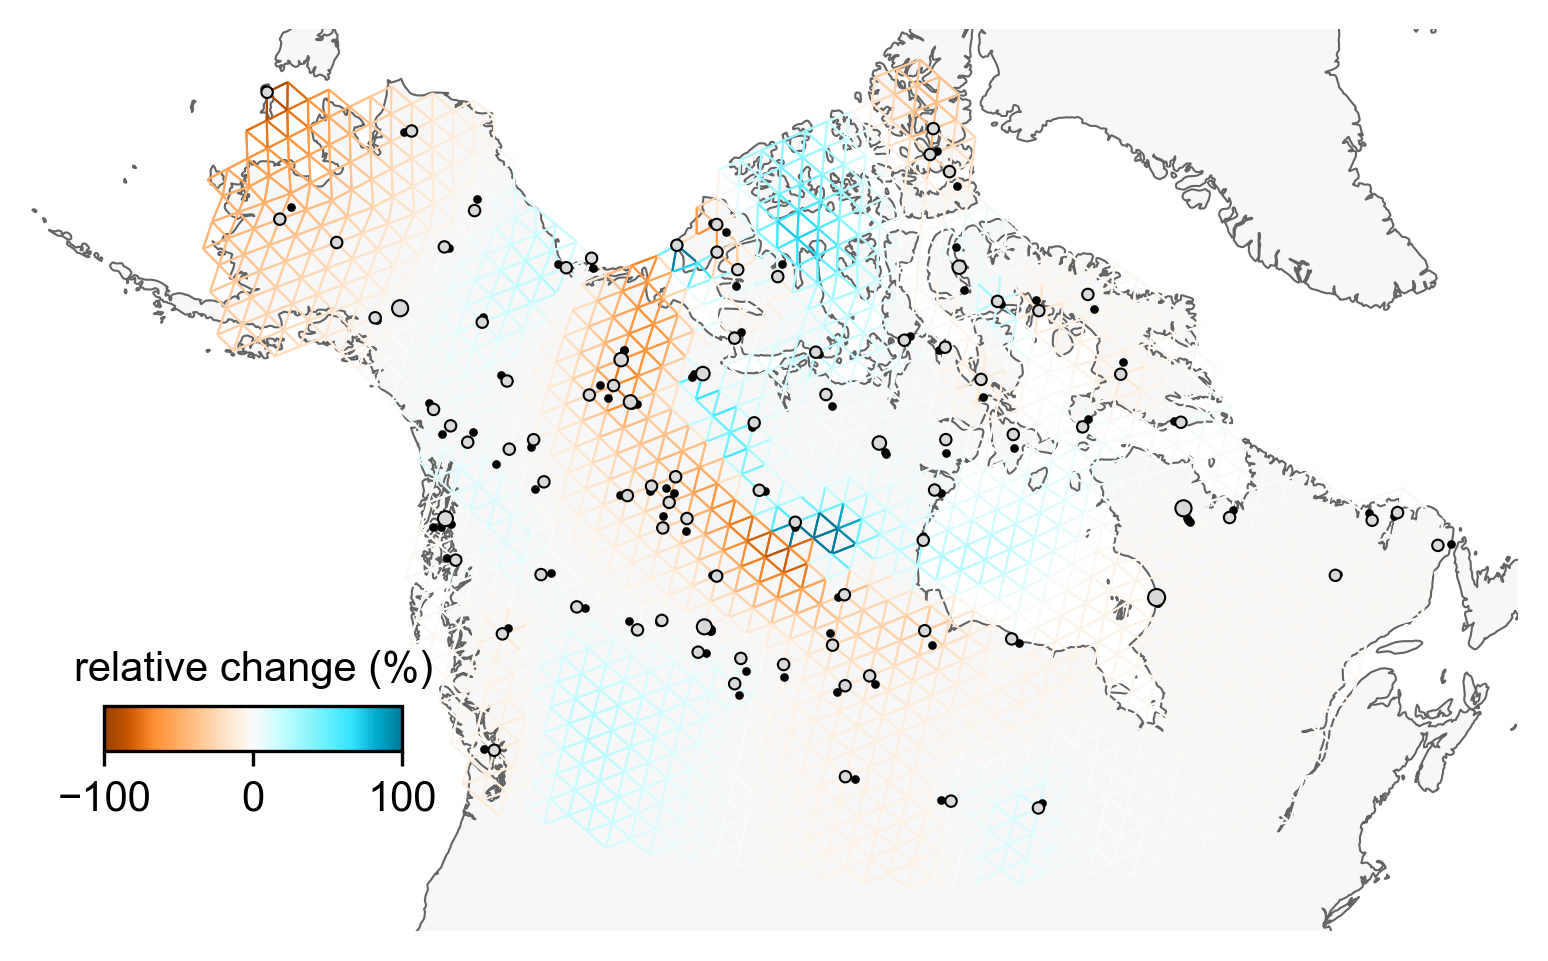

In [291]:
# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=4, cbar_font_size=10, cbar_ticklabelsize=10)
# v.draw_samples()
# v.draw_map(latlong=False); ax.set_extent([-145, -65, 37, 80]); v.draw_obs_nodes(); v.draw_edges(use_weights=True); v.draw_edge_colorbar()

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, oldweights=oldw,
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=4, cbar_font_size=10, cbar_ticklabelsize=10)
v.draw_samples()
v.draw_map(latlong=False); ax.set_extent([-145, -65, 37, 80]); v.draw_obs_nodes(); 
v.draw_edges(use_weights=True, use_foldchange=True); v.draw_edge_change_colorbar()

In [179]:
# lamb_grid = np.geomspace(2e-2,2e2,10,endpoint=True)[::-1]
# (outliers_df['dest.']
#            .value_counts()
#            .reset_index()
#            .merge(outliers_df.groupby('dest.')['pval'].min(), 
#                  left_on='index', 
#                  right_index=True)
#            .sort_values(['dest.', 'pval'], ascending=[False, True])
#            ['index'].tolist())
outliers_df.loc[outliers_df['dest.']==129]
# cvq_err = run_cv_joint(wolves_graph, lamb_grid=lamb_grid, lamb_q_grid=np.array([0.1, 1., 10.]), n_folds=10)

source  dest.          source (lat., long.) dest. (lat., long.)      pval  \
6     935    129  (56.188, -76.66200000000003)  (63.082, -147.234)  0.000882   

   raw diff.  
6  -0.034233

/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_12258/3440504101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df['source'].loc[outliers_df['dest.']==250] = 250
/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_12258/3440504101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df['dest.'].loc[outliers_df['dest.']==250] = 402


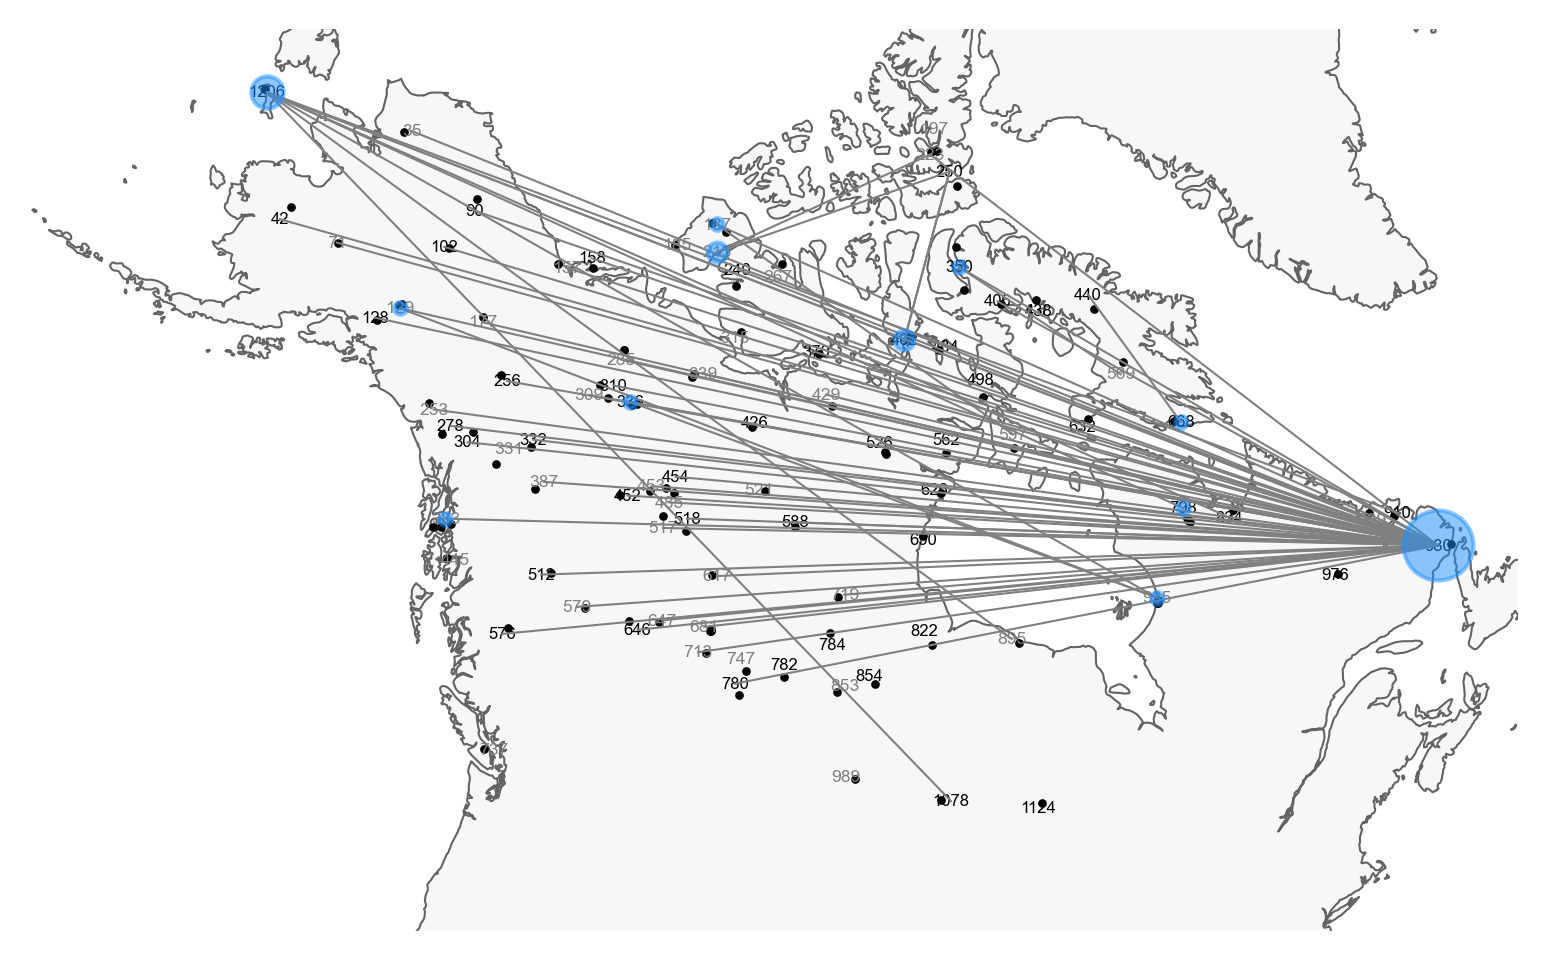

In [151]:
# outliers_df = wolves_graph.extract_outliers(fdr=0.1)
# outliers_df['source'].loc[outliers_df['dest.']==250] = 250
# outliers_df['dest.'].loc[outliers_df['dest.']==250] = 402


fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=4, cbar_font_size=10, cbar_ticklabelsize=10)
v.draw_samples()
v.draw_map(latlong=False); ax.set_extent([-145, -65, 37, 80]); v.draw_obs_nodes(use_ids=True); 
v.draw_outliers(outliers_df, linewidth=0.5)

In [234]:
# contour_dict = {}
# for e in [980, 1206, 213, 129, 187, 336, 350, 402, 668]:
#     contour_dict[e] = wolves_graph.calc_contour(destid=e,search_area='all')
# joint_contour_dict = {}
# for e in [980, 1206, 213, 129, 187, 336, 350, 402, 668, 935]:
#     joint_contour_dict[e] = wolves_graph.calc_joint_contour(contour_df=contour_dict[e],top=20,lamb=2.,lamb_q=50.)

# with open('/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/wolves/joint_contour_dict_new_ndim.pkl', 'rb') as fp:
#     joint_contour_dict = pickle.load(fp)

# import pickle
## with open('/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/wolves/joint_contour_dict_new_ndim.pkl', 'wb') as fp:
##     pickle.dump(joint_contour_dict, fp)
##     print('dictionary saved successfully to file')

inf

In [232]:
# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", obs_node_textsize=4, cbar_font_size=10, cbar_ticklabelsize=10)
# v.draw_samples()
# v.draw_map(latlong=False); ax.set_extent([-145, -65, 37, 80]); v.draw_obs_nodes(use_ids=True); 
# v.draw_edges(use_weights=True); v.draw_edge_colorbar()
# v.draw_c_colorbar(c_cbar_loc='upper right')
for e in [980, 1206, 129, 187, 336, 350, 402, 668, 935]:
    print(joint_contour_dict[e].iloc[np.argmax(joint_contour_dict[e]['scaled log-lik'])])
    # v.draw_loglik_contour(joint_contour_dict[e], levels=-5)
    # pe = joint_contour_dict[e]['(source, dest.)'].iloc[np.argmax(joint_contour_dict[e]['scaled log-lik'])]
    # v.draw_arrow([(pe[0],pe[1])],joint_contour_dict[e]['admix. prop.'].iloc[np.argmax(joint_contour_dict[e]['scaled log-lik'])],tw=3,hw=6,hl=8)

1.3743603173108066e+80
1.8686157047549809e+112
5.526614994168137e+102
9.373409103612797e+85
8.477851937083915e+18
2.0325509859378924e+25
4.8388946677687365e+43
3.382677630278411e+39
1339589416861311.5
3.93630570847709e+19
4.030202044667915e+45
7.317288531826714e+41
